# Designing Agents for the Sailing Challenge

In this notebook, we'll explore how to design and implement agents for the Sailing Challenge. We'll cover:

1. The requirements and interface for valid agents
2. Understanding the greedy agent example 
3. Implementing a simple reinforcement learning agent

By the end of this notebook, you'll have a clear understanding of how to create your own agents that can navigate the sailing environment effectively.

## Agent Requirements

All agents in the Sailing Challenge must implement a specific interface defined by the `BaseAgent` abstract class. Let's examine this class to understand what's required:

In [1]:
import sys
import os
import numpy as np

# Add the src directory to the path
sys.path.append(os.path.abspath('../src'))
sys.path.append(os.path.abspath('..'))

# Import the BaseAgent class
from src.agents.base_agent import BaseAgent

# Display the BaseAgent class documentation
#help(BaseAgent)

### Required Methods

As we can see from the `BaseAgent` class, any valid agent must implement:

1. **`act(observation)`**: The core decision-making method that takes the current observation and returns an action
   - Input: A numpy array containing [x, y, vx, vy, wx, wy, ...] representing position, velocity, wind, and the full wind field
   - Output: An integer in the range [0-8] representing the action to take

2. **`reset()`**: Resets the agent's internal state at the beginning of each episode
   - This is particularly important for agents that maintain memory or state across steps

3. **`seed(seed)`**: Sets the random seed for the agent to ensure reproducibility
   - This is crucial for evaluation and comparison of different agents

Additionally, while not strictly required, implementing `save()` and `load()` methods is recommended for storing and retrieving trained agent parameters.

### The Validation Process

When you submit an agent, it will be automatically validated against these requirements. The validation process checks:

1. If the agent class inherits from `BaseAgent`
2. If all required methods are implemented with correct parameters
3. If the agent produces valid actions (integers in range [0-8])
4. If the agent can interact with the environment without errors

Let's create a minimal valid agent to understand this process better:

In [2]:
class MinimalAgent(BaseAgent):
    """A minimal valid agent that meets all interface requirements."""
    
    def __init__(self):
        super().__init__()
        self.np_random = np.random.default_rng()
    
    def act(self, observation: np.ndarray) -> int:
        """Choose an action randomly."""
        return self.np_random.integers(0, 9)  # Random action from 0-8
    
    def reset(self) -> None:
        """Reset the agent."""
        pass  # Nothing to reset in this simple agent
    
    def seed(self, seed: int = None) -> None:
        """Set the random seed."""
        self.np_random = np.random.default_rng(seed)

# Create an instance of our minimal agent
minimal_agent = MinimalAgent()

### Testing the Agent's Validity

Let's make the agent do a few steps to check that everything is working

In [3]:
# Instead of validating the agent here, we'll just demonstrate it on a simple task
from src.env_sailing import SailingEnv

# Create a simple environment
env = SailingEnv()
observation, info = env.reset(seed=42)

# Initialize our minimal agent
minimal_agent = MinimalAgent()
minimal_agent.seed(42)

# Run the agent for a few steps
print("Running the minimal agent for 5 steps:")
for i in range(5):
    action = minimal_agent.act(observation)
    observation, reward, done, truncated, info = env.step(action)
    print(f"Step {i+1}: Action={action}, Position={info['position']}, Reward={reward}")

Running the minimal agent for 5 steps:
Step 1: Action=0, Position=[16  1], Reward=0.0
Step 2: Action=6, Position=[15  1], Reward=0.0
Step 3: Action=5, Position=[14  0], Reward=0.0
Step 4: Action=3, Position=[15  0], Reward=0.0
Step 5: Action=3, Position=[16  0], Reward=0.0


### Validating Your Agent

After creating your agent, you'll want to ensure it meets all the requirements of the challenge. There are two ways to validate your agent:

1. **Using the `validate_agent.ipynb` notebook:**
   - This notebook provides a comprehensive interface for testing your agent
   - It shows detailed validation results and explains any issues

2. **Using the command line:**
   ```bash
   cd src
   python test_agent_validity.py path/to/your_agent.py
   ```

We recommend using these tools after you've completed your agent implementation rather than trying to validate it during development.

For now, let's focus on understanding agent design principles and implementing effective strategies.

## Understanding the Observation and Action Space

To design effective agents, it's important to understand:

1. **What information is available to the agent (observations)**
2. **What actions the agent can take**

### Observation Space

The observation provided to your agent is a numpy array with the following structure:

`[x, y, vx, vy, wx, wy, flattened_wind_field]`


Where:
- `x, y`: Current position (grid coordinates)
- `vx, vy`: Current velocity vector 
- `wx, wy`: Wind vector at the current position
- `flattened_wind_field`: The entire wind field (can be reshaped to grid_size × grid_size × 2)

For simpler agents, you might only need to use the first 6 values. More sophisticated agents can use the full wind field to plan ahead.

### Action Space

The agent can choose from 9 possible actions:

- 0: Move North (up)
- 1: Move Northeast
- 2: Move East (right)
- 3: Move Southeast
- 4: Move South (down)
- 5: Move Southwest
- 6: Move West (left)
- 7: Move Northwest
- 8: Stay in place

Each action represents a desired direction for the boat to move. However, the actual movement will be influenced by the wind and sailing physics.

## The Naive Agent Example

Let's examine the built-in `NaiveAgent`, which provides a simple baseline implementation. This agent always tries to move North (toward the goal), regardless of wind conditions.

In [4]:
# Import the NaiveAgent
from src.agents.agent_naive import NaiveAgent

# Display the source code
import inspect
print(inspect.getsource(NaiveAgent))

class NaiveAgent(BaseAgent):
    """
    A naive agent for the Sailing Challenge.
    
    This is a very simple agent that always chooses to go North,
    regardless of wind conditions or position. It serves as a minimal
    working example that students can build upon.
    """
    
    def __init__(self):
        """Initialize the agent."""
        super().__init__()
        self.np_random = np.random.default_rng()
    
    def act(self, observation: np.ndarray) -> int:
        """
        Select an action based on the current observation.
        
        Args:
            observation: A numpy array containing the current observation.
                Format: [x, y, vx, vy, wx, wy] where:
                - (x, y) is the current position
                - (vx, vy) is the current velocity
                - (wx, wy) is the current wind vector
        
        Returns:
            action: An integer in [0, 8] representing the action to take:
                - 0: Move North
              

### Analysis of the Naive Agent

The `NaiveAgent` is extremely simple but illustrates the key requirements for a valid agent:

1. **Inheritance**: It inherits from `BaseAgent`
2. **Required Methods**: It implements all required methods (`act`, `reset`, `seed`)
3. **Action Selection**: It always returns action `0` (North)
4. **Simplicity**: It maintains no internal state and requires no complex logic

This agent provides a good baseline, but it has obvious limitations:

- It ignores wind conditions completely
- It will struggle when the wind is coming from the North
- It doesn't adapt its strategy based on the environment

Let's test the naive agent to see how well it performs:

In [27]:
from src.env_sailing import SailingEnv
from src.initial_windfields import get_initial_windfield

# Create an environment with a simple test initial windfield
env = SailingEnv(**get_initial_windfield('simple_static'))
naive_agent = NaiveAgent()

# Run a single episode
observation, info = env.reset(seed=42)
total_reward = 0
done = False
truncated = False
step_count = 0

print("Running the naive agent on the simple_static initial windfield:")
while not (done or truncated) and step_count < 1000:  # Limit to 100 steps
    action = naive_agent.act(observation)
    observation, reward, done, truncated, info = env.step(action)
    total_reward += reward
    step_count += 1
    
    # Print every 10 steps to avoid too much output
    if step_count % 10 == 0:
        print(f"Step {step_count}: Position={info['position']}, Reward={reward}")

print(f"\nEpisode finished after {step_count} steps with reward: {total_reward}")
print(f"Final position: {info['position']}")
print(f"Goal reached: {done}")

Running the naive agent on the simple_static initial windfield:
Step 10: Position=[16  7], Reward=0.0
Step 20: Position=[16 12], Reward=0.0
Step 30: Position=[16 13], Reward=0.0
Step 40: Position=[16 13], Reward=0.0
Step 50: Position=[16 14], Reward=0.0
Step 60: Position=[16 14], Reward=0.0
Step 70: Position=[16 15], Reward=0.0
Step 80: Position=[16 15], Reward=0.0
Step 90: Position=[16 16], Reward=0.0
Step 100: Position=[16 16], Reward=0.0
Step 110: Position=[16 17], Reward=0.0
Step 120: Position=[16 18], Reward=0.0
Step 130: Position=[16 18], Reward=0.0
Step 140: Position=[16 19], Reward=0.0
Step 150: Position=[16 19], Reward=0.0
Step 160: Position=[16 20], Reward=0.0
Step 170: Position=[16 20], Reward=0.0
Step 180: Position=[16 21], Reward=0.0
Step 190: Position=[16 21], Reward=0.0
Step 200: Position=[16 22], Reward=0.0
Step 210: Position=[16 22], Reward=0.0
Step 220: Position=[16 23], Reward=0.0
Step 230: Position=[16 24], Reward=0.0
Step 240: Position=[16 24], Reward=0.0
Step 250:

### Improving on the Naive Agent

The naive agent provides a good starting point, but there are many ways to improve it:

1. **Wind-Aware Agent**: Consider wind direction when choosing actions
2. **Goal-Directed Agent**: Calculate the direction to the goal and choose actions accordingly
3. **Physics-Based Agent**: Use sailing physics equations to determine the most efficient action

The key insight for sailing is that certain directions relative to the wind are more efficient than others:

- The sailing efficiency is highest when moving perpendicular to the wind (beam reach)
- It's difficult to sail directly into the wind (the "no-go zone" - less than 45° to the wind)
- The boat maintains momentum (inertia) between steps

Before diving into reinforcement learning, consider implementing a simple rule-based agent that incorporates these physics principles.

# Amélioration d'un agent naive avec le vent l'objectif et les équations physiques

In [24]:
class ImprovedSailingAgent(BaseAgent):
    """
    Un agent de voile amélioré qui utilise les principes de base de la physique de la navigation à voile.
    Cet agent tient compte de:
    1. La direction du vent
    2. L'angle optimal par rapport au vent
    3. La position de l'objectif
    """
    
    def __init__(self):
        super().__init__()
        self.np_random = np.random.default_rng()
        # Définir les angles optimaux pour la navigation
        self.optimal_wind_angles = [90, 120]  # Angles en degrés (perpendiculaire et grand largue)
        # La zone de non-navigation (no-go zone) est typiquement ±45° face au vent
        self.no_go_angle = 45
    
    def act(self, observation: np.ndarray) -> int:
        """
        Choisir une action en fonction des conditions de vent et de la position de l'objectif.
        
        Args:
            observation: Un tableau numpy contenant l'observation actuelle.
                Format: [x, y, vx, vy, wx, wy, ...] où:
                - (x, y) est la position actuelle
                - (vx, vy) est la vitesse actuelle
                - (wx, wy) est le vecteur de vent actuel
                - le reste contient le champ de vent complet
        
        Returns:
            int: L'action choisie (0-8)
        """
        # Extraire les informations pertinentes de l'observation
        position = observation[:2]  # [x, y]
        velocity = observation[2:4]  # [vx, vy]
        wind = observation[4:6]  # [wx, wy]
        
        # Dans un environnement SailingEnv typique, l'objectif est en haut de la grille
        # Nous supposons que l'objectif est à la position [16, 31] basé sur l'exemple
        goal_position = np.array([16, 31])
        
        # Calculer le vecteur vers l'objectif
        direction_to_goal = goal_position - position
        distance_to_goal = np.linalg.norm(direction_to_goal)
        
        # Si nous sommes très proches de l'objectif, essayer de l'atteindre directement
        if distance_to_goal < 2.0:
            return self._get_action_towards_direction(direction_to_goal)
        
        # Calculer l'angle du vent (en degrés)
        wind_angle = np.degrees(np.arctan2(wind[1], wind[0]))
        
        # Calculer l'angle vers l'objectif (en degrés)
        goal_angle = np.degrees(np.arctan2(direction_to_goal[1], direction_to_goal[0]))
        
        # Angle relatif entre le vent et la direction vers l'objectif
        relative_angle = (goal_angle - wind_angle) % 360
        
        # Vérifier si l'objectif est dans la zone de non-navigation
        if relative_angle < self.no_go_angle or relative_angle > 360 - self.no_go_angle:
            # L'objectif est face au vent, nous devons tacker (zigzaguer)
            return self._tacking_strategy(wind_angle, position)
        else:
            # Nous pouvons naviguer plus directement vers l'objectif
            # Mais ajustons notre angle pour optimiser la vitesse
            return self._optimize_sailing_angle(wind_angle, goal_angle, direction_to_goal)
    
    def _get_action_towards_direction(self, direction):
        """Convertit un vecteur de direction en action discrète (0-8)."""
        # Normaliser le vecteur de direction
        if np.linalg.norm(direction) > 0:
            direction = direction / np.linalg.norm(direction)
        
        # Cartographier les 8 directions aux actions
        # [N, NE, E, SE, S, SW, W, NW]
        actions_map = [
            (0, 1),    # 0: Nord
            (1, 1),    # 1: Nord-Est
            (1, 0),    # 2: Est
            (1, -1),   # 3: Sud-Est
            (0, -1),   # 4: Sud
            (-1, -1),  # 5: Sud-Ouest
            (-1, 0),   # 6: Ouest
            (-1, 1),   # 7: Nord-Ouest
        ]
        
        # Calculer l'action qui correspond le mieux à la direction
        best_action = 0
        best_similarity = -float('inf')
        
        for i, action_dir in enumerate(actions_map):
            similarity = direction[0] * action_dir[0] + direction[1] * action_dir[1]
            if similarity > best_similarity:
                best_similarity = similarity
                best_action = i
        
        return best_action
    
    def _tacking_strategy(self, wind_angle, position):
        """
        Implémente une stratégie de tacking (virement de bord) lorsque l'objectif est face au vent.
        Alterne entre naviguer à environ 45-60° de chaque côté du vent.
        """
        # Décider de quel côté virer en fonction de la position x
        # Cela crée un zigzag naturel
        if position[0] < 16:  # À gauche du centre, virer à tribord
            tack_angle = wind_angle + 60
        else:  # À droite du centre, virer à bâbord
            tack_angle = wind_angle - 60
        
        # Convertir l'angle en vecteur de direction
        tack_direction = np.array([np.cos(np.radians(tack_angle)), np.sin(np.radians(tack_angle))])
        
        # Obtenir l'action correspondante
        return self._get_action_towards_direction(tack_direction)
    
    def _optimize_sailing_angle(self, wind_angle, goal_angle, direction_to_goal):
        """
        Optimise l'angle de navigation pour maximiser la vitesse,
        en se basant sur les angles optimaux par rapport au vent.
        """
        # Trouver l'angle optimal le plus proche de notre direction vers l'objectif
        best_angle = goal_angle  # Par défaut, viser directement l'objectif
        
        # Calculer les angles absolus optimaux (dans les deux sens)
        optimal_angles = []
        for optimal in self.optimal_wind_angles:
            optimal_angles.append((wind_angle + optimal) % 360)
            optimal_angles.append((wind_angle - optimal) % 360)
        
        # Trouver l'angle optimal le plus proche de notre direction vers l'objectif
        angle_diff = [abs((angle - goal_angle) % 360) for angle in optimal_angles]
        min_diff_index = np.argmin(angle_diff)
        
        # Si la différence d'angle est significative, utiliser l'angle optimal
        if angle_diff[min_diff_index] < 45:
            best_angle = optimal_angles[min_diff_index]
        
        # Convertir l'angle en vecteur de direction
        optimal_direction = np.array([np.cos(np.radians(best_angle)), np.sin(np.radians(best_angle))])
        
        # Mélanger la direction optimale avec la direction vers l'objectif
        # Cela permet de progresser vers l'objectif tout en maintenant une bonne vitesse
        mixed_direction = 0.7 * optimal_direction + 0.3 * (direction_to_goal / np.linalg.norm(direction_to_goal))
        
        return self._get_action_towards_direction(mixed_direction)
    
    def reset(self) -> None:
        """Réinitialiser l'agent."""
        pass  # Rien à réinitialiser pour cet agent simple
    
    def seed(self, seed: int = None) -> None:
        """Définir la graine aléatoire."""
        self.np_random = np.random.default_rng(seed)

In [26]:
from src.env_sailing import SailingEnv
from src.initial_windfields import get_initial_windfield

# Create an environment with a simple test initial windfield
env = SailingEnv(**get_initial_windfield('simple_static'))
naive_agent = ImprovedSailingAgent()

# Run a single episode
observation, info = env.reset(seed=42)
total_reward = 0
done = False
truncated = False
step_count = 0

print("Running the naive agent on the simple_static initial windfield:")
while not (done or truncated) and step_count < 1000:  # Limit to 100 steps
    action = naive_agent.act(observation)
    observation, reward, done, truncated, info = env.step(action)
    total_reward += reward
    step_count += 1
    
    # Print every 10 steps to avoid too much output
    if step_count % 10 == 0:
        print(f"Step {step_count}: Position={info['position']}, Reward={reward}")

print(f"\nEpisode finished after {step_count} steps with reward: {total_reward}")
print(f"Final position: {info['position']}")
print(f"Goal reached: {done}")

Running the naive agent on the simple_static initial windfield:
Step 10: Position=[ 6 11], Reward=0.0
Step 20: Position=[ 6 11], Reward=0.0
Step 30: Position=[ 7 12], Reward=0.0
Step 40: Position=[ 8 13], Reward=0.0
Step 50: Position=[ 8 13], Reward=0.0
Step 60: Position=[ 8 15], Reward=0.0
Step 70: Position=[ 7 17], Reward=0.0
Step 80: Position=[ 7 17], Reward=0.0
Step 90: Position=[ 8 18], Reward=0.0
Step 100: Position=[ 9 19], Reward=0.0
Step 110: Position=[ 9 19], Reward=0.0
Step 120: Position=[10 20], Reward=0.0
Step 130: Position=[10 20], Reward=0.0
Step 140: Position=[11 21], Reward=0.0
Step 150: Position=[11 21], Reward=0.0
Step 160: Position=[11 23], Reward=0.0
Step 170: Position=[11 24], Reward=0.0
Step 180: Position=[12 24], Reward=0.0
Step 190: Position=[13 25], Reward=0.0
Step 200: Position=[13 25], Reward=0.0
Step 210: Position=[13 27], Reward=0.0
Step 220: Position=[13 27], Reward=0.0
Step 230: Position=[14 28], Reward=0.0
Step 240: Position=[14 29], Reward=0.0
Step 250:

In [30]:
class AdvancedSailingAgent(BaseAgent):
    """
    Agent de voile avancé avec optimisation complète basée sur la physique de la voile
    et une planification de trajectoire intelligente.
    """
    
    def __init__(self):
        super().__init__()
        self.np_random = np.random.default_rng()
        
        # Paramètres de navigation à voile
        self.polar_data = self._create_sailing_polar()  # Données d'efficacité polaire
        self.tacking_distance = 3.0  # Distance minimale avant de virer de bord
        self.last_tack_position = None  # Pour éviter le virement de bord trop fréquent
        self.last_actions = []  # Historique des actions pour la stabilité
        self.action_history_size = 3  # Nombre d'actions à stocker dans l'historique
        self.wind_prediction_horizon = 5  # Nombre de pas pour la prédiction du vent
        
        # Paramètres adaptatifs
        self.adaptation_rate = 0.1  # Taux d'adaptation aux conditions
        self.performance_history = []  # Historique des performances
        
        # Stratégie globale
        self.upwind_strategy = "tacking"  # tacking ou long_tacking
        self.downwind_strategy = "direct"  # direct ou gybing
        
        # État de navigation
        self.current_leg = "upwind"  # upwind, reaching, downwind
        self.tack_side = "port"  # port (bâbord) ou starboard (tribord)
        
    def _create_sailing_polar(self):
        """
        Crée une table polaire d'efficacité de navigation basée sur l'angle au vent.
        Renvoie un dictionnaire avec {angle: efficacité} où l'angle est en degrés.
        """
        polar = {}
        
        # Zone de non-navigation (irons) - très faible efficacité
        for angle in range(0, 46):
            polar[angle] = 0.1
            polar[360-angle] = 0.1
        
        # Près (close-hauled) - efficacité modérée
        for angle in range(46, 80):
            factor = (angle - 45) / 35  # Augmentation progressive de l'efficacité
            polar[angle] = 0.3 + 0.4 * factor
            polar[360-angle] = 0.3 + 0.4 * factor
        
        # Travers (beam reach) - haute efficacité
        for angle in range(80, 120):
            polar[angle] = 0.9 + 0.1 * np.sin((angle - 80) * np.pi / 80)
            polar[360-angle] = 0.9 + 0.1 * np.sin((angle - 80) * np.pi / 80)
        
        # Grand largue (broad reach) - très haute efficacité
        for angle in range(120, 150):
            polar[angle] = 0.95
            polar[360-angle] = 0.95
        
        # Vent arrière (running) - haute efficacité mais pas optimale
        for angle in range(150, 181):
            factor = (180 - angle) / 30  # Diminution progressive
            polar[angle] = 0.85 + 0.1 * factor
            polar[360-angle] = 0.85 + 0.1 * factor
        
        return polar
    
    def act(self, observation: np.ndarray) -> int:
        """
        Sélectionne l'action optimale basée sur une analyse complète des conditions.
        """
        # Extraire les informations de l'observation
        position = observation[:2]  # [x, y]
        velocity = observation[2:4]  # [vx, vy]
        wind_at_boat = observation[4:6]  # [wx, wy]
        
        # Extraire et analyser le champ de vent complet
        wind_field_data = observation[6:]
        wind_field = self._reconstruct_wind_field(wind_field_data)
        
        # Définir la position de l'objectif (basée sur l'exemple précédent)
        goal_position = np.array([16, 31])
        
        # Calcul des vecteurs et angles principaux
        direction_to_goal = goal_position - position
        distance_to_goal = np.linalg.norm(direction_to_goal)
        
        wind_speed = np.linalg.norm(wind_at_boat)
        wind_angle = np.degrees(np.arctan2(wind_at_boat[1], wind_at_boat[0])) % 360
        
        goal_angle = np.degrees(np.arctan2(direction_to_goal[1], direction_to_goal[0])) % 360
        
        # Angle du bateau (basé sur la vitesse si disponible)
        boat_angle = None
        if np.linalg.norm(velocity) > 0.01:
            boat_angle = np.degrees(np.arctan2(velocity[1], velocity[0])) % 360
        else:
            # Si le bateau n'a pas de vitesse significative, utiliser l'angle vers l'objectif
            boat_angle = goal_angle
        
        # Angle relatif entre le vent et la direction du bateau
        wind_relative_angle = (boat_angle - wind_angle) % 360
        
        # Analyse de l'environnement
        upwind_condition = self._is_upwind(goal_angle, wind_angle)
        downwind_condition = self._is_downwind(goal_angle, wind_angle)
        
        # Déterminer la stratégie en fonction de la situation
        if distance_to_goal < 2.0:
            # Près de l'objectif - naviguer directement
            return self._get_action_towards_direction(direction_to_goal)
        elif upwind_condition:
            # Navigation contre le vent - utiliser la stratégie de louvoyage
            return self._upwind_strategy(position, wind_angle, boat_angle, goal_position, wind_field)
        elif downwind_condition:
            # Navigation avec le vent arrière
            return self._downwind_strategy(position, wind_angle, boat_angle, goal_position, wind_field)
        else:
            # Navigation au travers ou au largue - optimiser l'angle
            return self._optimal_reaching_strategy(position, velocity, wind_angle, boat_angle, goal_position, wind_field)
    
    def _reconstruct_wind_field(self, wind_field_data):
        """
        Reconstruit le champ de vent à partir des données aplaties.
        Pour simplifier, nous retournons les données brutes ici.
        Dans une implémentation complète, vous reconstruiriez une grille 2D.
        """
        return wind_field_data
    
    def _is_upwind(self, goal_angle, wind_angle):
        """Détermine si l'objectif est face au vent (± zone de non-navigation)."""
        relative_angle = (goal_angle - wind_angle) % 360
        return relative_angle < 50 or relative_angle > 310
    
    def _is_downwind(self, goal_angle, wind_angle):
        """Détermine si l'objectif est sous le vent."""
        relative_angle = (goal_angle - wind_angle) % 360
        return 160 < relative_angle < 200
    
    def _get_sailing_efficiency(self, wind_relative_angle):
        """Obtient l'efficacité de navigation pour un angle donné par rapport au vent."""
        angle = int(wind_relative_angle % 360)
        return self.polar_data.get(angle, 0.5)  # Valeur par défaut si l'angle n'est pas dans la table
    
    def _upwind_strategy(self, position, wind_angle, boat_angle, goal_position, wind_field):
        """
        Stratégie de navigation au près (contre le vent).
        Implémente le louvoyage (tacking) de manière optimisée.
        """
        # Calculer la ligne imaginaire de progression vers l'objectif
        goal_direction = goal_position - position
        
        # Déterminer le côté du tack en fonction de la position actuelle
        # Stratégie: zigzag autour de la ligne vers l'objectif
        cross_track = self._cross_track_distance(position, goal_position)
        
        # Changement de bord si nécessaire
        if cross_track > self.tacking_distance:
            self.tack_side = "port" if self.tack_side == "starboard" else "starboard"
            self.last_tack_position = position.copy()
        
        # Calculer l'angle optimal de près
        if self.tack_side == "port":
            tack_angle = (wind_angle + 50) % 360  # 50° tribord du vent
        else:
            tack_angle = (wind_angle - 50) % 360  # 50° bâbord du vent
        
        # Vecteur de direction pour cet angle
        tack_direction = np.array([np.cos(np.radians(tack_angle)), np.sin(np.radians(tack_angle))])
        
        # Vérifier si nous nous éloignons trop de l'objectif
        direction_to_goal = goal_position - position
        angle_to_goal = np.degrees(np.arctan2(direction_to_goal[1], direction_to_goal[0])) % 360
        
        # Si le tack nous éloigne trop de la direction générale, envisager de virer
        angle_diff = min((tack_angle - angle_to_goal) % 360, (angle_to_goal - tack_angle) % 360)
        if angle_diff > 100:  # Nous nous éloignons trop
            # Virer de bord si nous avons parcouru une distance minimale depuis le dernier virement
            if self.last_tack_position is None or np.linalg.norm(position - self.last_tack_position) > 5.0:
                self.tack_side = "port" if self.tack_side == "starboard" else "starboard"
                self.last_tack_position = position.copy()
                # Recalculer l'angle après le virement
                if self.tack_side == "port":
                    tack_angle = (wind_angle + 50) % 360
                else:
                    tack_angle = (wind_angle - 50) % 360
                tack_direction = np.array([np.cos(np.radians(tack_angle)), np.sin(np.radians(tack_angle))])
        
        # Obtenir l'action correspondante avec un léger facteur de stabilité
        action = self._get_action_towards_direction(tack_direction)
        
        # Stabiliser l'action en utilisant l'historique
        if len(self.last_actions) > 0:
            # 80% nouvelle action, 20% moyenne des actions précédentes pour éviter les oscillations
            prev_action = self.last_actions[-1]
            if abs(action - prev_action) <= 1 or abs(action - prev_action) >= 7:  # Actions similaires ou opposées
                action = action  # Garder la nouvelle action
            else:
                # Petite stabilisation
                action = action if self.np_random.random() < 0.8 else prev_action
        
        # Mettre à jour l'historique des actions
        self.last_actions.append(action)
        if len(self.last_actions) > self.action_history_size:
            self.last_actions.pop(0)
        
        return action
    
    def _downwind_strategy(self, position, wind_angle, boat_angle, goal_position, wind_field):
        """
        Stratégie de navigation au portant (avec le vent arrière).
        Implémente une navigation directe ou en zigzag selon les conditions.
        """
        # Direction vers l'objectif
        direction_to_goal = goal_position - position
        goal_angle = np.degrees(np.arctan2(direction_to_goal[1], direction_to_goal[0])) % 360
        
        # Pour le vent arrière, la navigation directe n'est pas toujours optimale
        # Nous pouvons naviguer légèrement de biais pour plus d'efficacité
        
        # Calculer les angles optimaux de chaque côté
        port_angle = (wind_angle + 150) % 360
        starboard_angle = (wind_angle - 150) % 360
        
        # Déterminer quel angle est le plus proche de la direction vers l'objectif
        port_diff = min((port_angle - goal_angle) % 360, (goal_angle - port_angle) % 360)
        starboard_diff = min((starboard_angle - goal_angle) % 360, (goal_angle - starboard_angle) % 360)
        
        # Choisir l'angle optimal
        if port_diff < starboard_diff:
            optimal_angle = port_angle
        else:
            optimal_angle = starboard_angle
        
        # Mixer avec la direction de l'objectif pour garantir la progression
        optimal_direction = np.array([np.cos(np.radians(optimal_angle)), np.sin(np.radians(optimal_angle))])
        goal_direction = direction_to_goal / np.linalg.norm(direction_to_goal)
        
        mixed_direction = 0.6 * optimal_direction + 0.4 * goal_direction
        
        # Obtenir l'action correspondante
        action = self._get_action_towards_direction(mixed_direction)
        
        # Stabiliser l'action
        if len(self.last_actions) > 0:
            prev_action = self.last_actions[-1]
            if action != prev_action and self.np_random.random() < 0.3:
                action = prev_action
        
        # Mettre à jour l'historique
        self.last_actions.append(action)
        if len(self.last_actions) > self.action_history_size:
            self.last_actions.pop(0)
        
        return action
    
    def _optimal_reaching_strategy(self, position, velocity, wind_angle, boat_angle, goal_position, wind_field):
        """
        Stratégie optimale pour la navigation au travers ou au largue.
        Maximise la vitesse tout en se dirigeant vers l'objectif.
        """
        # Direction et angle vers l'objectif
        direction_to_goal = goal_position - position
        goal_angle = np.degrees(np.arctan2(direction_to_goal[1], direction_to_goal[0])) % 360
        
        # Angles de navigation optimaux (au travers)
        optimal_angles = [(wind_angle + 90) % 360, (wind_angle - 90) % 360, 
                          (wind_angle + 120) % 360, (wind_angle - 120) % 360]
        
        # Trouver l'angle optimal le plus proche de notre direction
        best_angle = None
        min_diff = 180
        
        for angle in optimal_angles:
            diff = min((angle - goal_angle) % 360, (goal_angle - angle) % 360)
            if diff < min_diff:
                min_diff = diff
                best_angle = angle
        
        # Direction optimale
        optimal_direction = np.array([np.cos(np.radians(best_angle)), np.sin(np.radians(best_angle))])
        
        # Équilibrer entre direction optimale et direction vers l'objectif
        # Plus nous sommes proches de l'objectif, plus nous privilégions la direction directe
        distance = np.linalg.norm(direction_to_goal)
        goal_weight = max(0.3, min(0.8, 1.0 - distance / 20.0))
        
        goal_direction = direction_to_goal / np.linalg.norm(direction_to_goal)
        mixed_direction = (1 - goal_weight) * optimal_direction + goal_weight * goal_direction
        
        # Obtenir l'action
        action = self._get_action_towards_direction(mixed_direction)
        
        # Stabilisation
        if len(self.last_actions) > 0:
            prev_action = self.last_actions[-1]
            if action != prev_action and self.np_random.random() < 0.2:
                action = prev_action
        
        # Mettre à jour l'historique
        self.last_actions.append(action)
        if len(self.last_actions) > self.action_history_size:
            self.last_actions.pop(0)
        
        return action
    
    def _get_action_towards_direction(self, direction):
        """Convertit un vecteur de direction en action discrète (0-8)."""
        # Normaliser le vecteur
        if np.linalg.norm(direction) > 0:
            direction = direction / np.linalg.norm(direction)
        
        # Cartographier les 8 directions aux actions
        actions_map = [
            (0, 1),    # 0: Nord
            (1, 1),    # 1: Nord-Est
            (1, 0),    # 2: Est
            (1, -1),   # 3: Sud-Est
            (0, -1),   # 4: Sud
            (-1, -1),  # 5: Sud-Ouest
            (-1, 0),   # 6: Ouest
            (-1, 1),   # 7: Nord-Ouest
        ]
        
        # Ajouter l'action "rester sur place"
        actions_map.append((0, 0))  # 8: Rester sur place
        
        # Trouver l'action la plus similaire à la direction
        best_action = 0
        best_similarity = -float('inf')
        
        for i, action_dir in enumerate(actions_map):
            # Pour "rester sur place", utiliser une similarité spéciale
            if i == 8:
                # N'utiliser cette action que si la direction est très faible
                if np.linalg.norm(direction) < 0.2:
                    similarity = 1.0
                else:
                    similarity = -1.0
            else:
                similarity = direction[0] * action_dir[0] + direction[1] * action_dir[1]
            
            if similarity > best_similarity:
                best_similarity = similarity
                best_action = i
        
        return best_action
    
    def _cross_track_distance(self, position, goal_position):
        """
        Calcule la distance perpendiculaire (cross-track) entre la position actuelle
        et la ligne droite allant de la position initiale à l'objectif.
        Pour simplifier, nous supposons que la position initiale est [16, 0].
        """
        start_position = np.array([16, 0])
        
        # Vecteur de la ligne (de départ à objectif)
        track_vector = goal_position - start_position
        track_length = np.linalg.norm(track_vector)
        
        if track_length == 0:
            return np.linalg.norm(position - start_position)
        
        # Normaliser
        track_unit = track_vector / track_length
        
        # Vecteur de la position actuelle au point de départ
        pos_vector = position - start_position
        
        # Projection sur la ligne
        projection = np.dot(pos_vector, track_unit)
        
        # Calculer le point projeté
        projected_point = start_position + projection * track_unit
        
        # Distance perpendiculaire
        return np.linalg.norm(position - projected_point)
    
    def reset(self) -> None:
        """Réinitialiser l'agent."""
        self.last_tack_position = None
        self.last_actions = []
        self.performance_history = []
        self.tack_side = "port" if self.np_random.random() < 0.5 else "starboard"
    
    def seed(self, seed: int = None) -> None:
        """Définir la graine aléatoire."""
        self.np_random = np.random.default_rng(seed)

In [31]:
from src.env_sailing import SailingEnv
from src.initial_windfields import get_initial_windfield

# Create an environment with a simple test initial windfield
env = SailingEnv(**get_initial_windfield('simple_static'))
naive_agent = AdvancedSailingAgent()

# Run a single episode
observation, info = env.reset(seed=42)
total_reward = 0
done = False
truncated = False
step_count = 0

print("Running the naive agent on the simple_static initial windfield:")
while not (done or truncated) and step_count < 1000:  # Limit to 100 steps
    action = naive_agent.act(observation)
    observation, reward, done, truncated, info = env.step(action)
    total_reward += reward
    step_count += 1
    
    # Print every 10 steps to avoid too much output
    if step_count % 10 == 0:
        print(f"Step {step_count}: Position={info['position']}, Reward={reward}")

print(f"\nEpisode finished after {step_count} steps with reward: {total_reward}")
print(f"Final position: {info['position']}")
print(f"Goal reached: {done}")

Running the naive agent on the simple_static initial windfield:
Step 10: Position=[ 6 11], Reward=0.0
Step 20: Position=[ 6 11], Reward=0.0
Step 30: Position=[ 7 12], Reward=0.0
Step 40: Position=[ 8 13], Reward=0.0
Step 50: Position=[ 8 13], Reward=0.0
Step 60: Position=[ 8 15], Reward=0.0
Step 70: Position=[ 7 17], Reward=0.0
Step 80: Position=[ 7 17], Reward=0.0
Step 90: Position=[ 8 18], Reward=0.0
Step 100: Position=[ 9 19], Reward=0.0
Step 110: Position=[ 9 19], Reward=0.0
Step 120: Position=[10 20], Reward=0.0
Step 130: Position=[10 20], Reward=0.0
Step 140: Position=[11 21], Reward=0.0
Step 150: Position=[11 21], Reward=0.0
Step 160: Position=[12 22], Reward=0.0
Step 170: Position=[13 23], Reward=0.0
Step 180: Position=[13 23], Reward=0.0
Step 190: Position=[14 24], Reward=0.0
Step 200: Position=[14 24], Reward=0.0
Step 210: Position=[15 25], Reward=0.0
Step 220: Position=[15 25], Reward=0.0
Step 230: Position=[15 27], Reward=0.0
Step 240: Position=[15 28], Reward=0.0
Step 250:

## Implementing a Simple RL Agent

## Implementing a Q-Learning Agent

Now let's implement a basic Q-learning agent for our sailing environment. Q-learning is a model-free reinforcement learning algorithm that learns to make decisions by estimating the value of state-action pairs.

Our implementation will use a simplified state representation based on:
1. Agent's current position
2. Agent's current velocity 
3. Local wind at the agent's position

This simplified approach makes the agent more interpretable and faster to train, while still capturing essential local information for effective navigation.

In [29]:
class QLearningAgent(BaseAgent):
    """A simple Q-learning agent for the sailing environment using only local information."""
    
    def __init__(self, learning_rate=0.1, discount_factor=0.9, exploration_rate=0.1):
        super().__init__()
        self.np_random = np.random.default_rng()
        
        # Learning parameters
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.exploration_rate = exploration_rate
        
        # State discretization parameters
        self.position_bins = 8     # Discretize the grid into 8x8
        self.velocity_bins = 4     # Discretize velocity into 4 bins
        self.wind_bins = 8         # Discretize wind directions into 8 bins
        
        # Initialize Q-table
        # State space: position_x, position_y, velocity_direction, wind_direction
        # Action space: 9 possible actions
        self.q_table = {}
        
    def discretize_state(self, observation):
        """Convert continuous observation to discrete state for Q-table lookup."""
        # Extract position, velocity and wind from observation
        x, y = observation[0], observation[1]
        vx, vy = observation[2], observation[3]
        wx, wy = observation[4], observation[5]
        
        # Discretize position (assume 32x32 grid)
        grid_size = 32
        x_bin = min(int(x / grid_size * self.position_bins), self.position_bins - 1)
        y_bin = min(int(y / grid_size * self.position_bins), self.position_bins - 1)
        
        # Discretize velocity direction (ignoring magnitude for simplicity)
        v_magnitude = np.sqrt(vx**2 + vy**2)
        if v_magnitude < 0.1:  # If velocity is very small, consider it as a separate bin
            v_bin = 0
        else:
            v_direction = np.arctan2(vy, vx)  # Range: [-pi, pi]
            v_bin = int(((v_direction + np.pi) / (2 * np.pi) * (self.velocity_bins-1)) + 1) % self.velocity_bins
        
        # Discretize wind direction
        wind_direction = np.arctan2(wy, wx)  # Range: [-pi, pi]
        wind_bin = int(((wind_direction + np.pi) / (2 * np.pi) * self.wind_bins)) % self.wind_bins
        
        # Return discrete state tuple
        return (x_bin, y_bin, v_bin, wind_bin)
        
    def act(self, observation):
        """Choose an action using epsilon-greedy policy."""
        # Discretize the state
        state = self.discretize_state(observation)
        
        # Epsilon-greedy action selection
        if self.np_random.random() < self.exploration_rate:
            # Explore: choose a random action
            return self.np_random.integers(0, 9)
        else:
            # Exploit: choose the best action according to Q-table
            if state not in self.q_table:
                # If state not in Q-table, initialize it
                self.q_table[state] = np.zeros(9)
            
            # Return action with highest Q-value
            return np.argmax(self.q_table[state])
    
    def learn(self, state, action, reward, next_state):
        """Update Q-table based on observed transition."""
        # Initialize Q-values if states not in table
        if state not in self.q_table:
            self.q_table[state] = np.zeros(9)
        if next_state not in self.q_table:
            self.q_table[next_state] = np.zeros(9)
        
        # Q-learning update
        best_next_action = np.argmax(self.q_table[next_state])
        td_target = reward + self.discount_factor * self.q_table[next_state][best_next_action]
        td_error = td_target - self.q_table[state][action]
        self.q_table[state][action] += self.learning_rate * td_error
    
    def reset(self):
        """Reset the agent for a new episode."""
        # Nothing to reset for Q-learning agent
        pass
        
    def seed(self, seed=None):
        """Set the random seed."""
        self.np_random = np.random.default_rng(seed)
        
    def save(self, path):
        """Save the Q-table to a file."""
        import pickle
        with open(path, 'wb') as f:
            pickle.dump(self.q_table, f)
            
    def load(self, path):
        """Load the Q-table from a file."""
        import pickle
        with open(path, 'rb') as f:
            self.q_table = pickle.load(f)

### Training the Q-Learning Agent

Now let's train our Q-learning agent on a simple initial windfield. We'll start with a small number of episodes (10) to demonstrate the process.

In [7]:
# Create our Q-learning agent
ql_agent = QLearningAgent(learning_rate=0.1, discount_factor=0.99, exploration_rate=0.2)

# Set fixed seed for reproducibility
np.random.seed(42)
ql_agent.seed(42)

# Create environment with a simple initial windfield
env = SailingEnv(**get_initial_windfield('simple_static'))

# Training parameters
num_episodes = 10  # Small number for debugging
max_steps = 1000

# Training loop
print("Starting training with 10 episodes (debug run)...")
for episode in range(num_episodes):
    # Reset environment and get initial state
    observation, info = env.reset(seed=episode)  # Different seed each episode
    state = ql_agent.discretize_state(observation)
    
    total_reward = 0
    
    for step in range(max_steps):
        # Select action and take step
        action = ql_agent.act(observation)
        next_observation, reward, done, truncated, info = env.step(action)
        next_state = ql_agent.discretize_state(next_observation)
        
        # Update Q-table
        ql_agent.learn(state, action, reward, next_state)
        
        # Update state and total reward
        state = next_state
        observation = next_observation
        total_reward += reward
        
        # Break if episode is done
        if done or truncated:
            break
    
    print(f"Episode {episode+1}: Steps={step+1}, Reward={total_reward}, " +
          f"Position={info['position']}, Goal reached={done}")
    
    # Update exploration rate (optional: decrease exploration over time)
    ql_agent.exploration_rate = max(0.05, ql_agent.exploration_rate * 0.95)

print("\nDebug training completed!")
print(f"Q-table size: {len(ql_agent.q_table)} states")

Starting training with 10 episodes (debug run)...
Episode 1: Steps=1000, Reward=0.0, Position=[ 8 30], Goal reached=True
Episode 2: Steps=1000, Reward=0.0, Position=[ 1 30], Goal reached=True


Episode 3: Steps=1000, Reward=0.0, Position=[ 0 31], Goal reached=True
Episode 4: Steps=1000, Reward=0.0, Position=[ 1 24], Goal reached=True
Episode 5: Steps=1000, Reward=0.0, Position=[ 4 30], Goal reached=True
Episode 6: Steps=1000, Reward=0.0, Position=[ 0 27], Goal reached=True
Episode 7: Steps=1000, Reward=0.0, Position=[ 4 31], Goal reached=True
Episode 8: Steps=1000, Reward=0.0, Position=[ 7 29], Goal reached=True
Episode 9: Steps=1000, Reward=0.0, Position=[ 1 31], Goal reached=True
Episode 10: Steps=716, Reward=100.0, Position=[15 30], Goal reached=True

Debug training completed!
Q-table size: 215 states


méthode hybride

In [34]:
class HybridSailingQLearningAgent(BaseAgent):
    """
    Agent hybride combinant Q-learning et connaissances de navigation à voile.
    
    Cet agent utilise:
    1. Q-learning pour l'adaptation et l'apprentissage des politiques optimales
    2. Connaissances physiques de la voile pour:
       - Une meilleure représentation des états
       - Une initialisation intelligente du Q-table
       - Un mécanisme d'action guidée pour accélérer l'apprentissage
    """
    
    def __init__(self, learning_rate=0.1, discount_factor=0.99, exploration_rate=0.2):
        super().__init__()
        self.np_random = np.random.default_rng()
        
        # Paramètres d'apprentissage
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.exploration_rate = exploration_rate
        self.initial_exploration_rate = exploration_rate
        self.min_exploration_rate = 0.05
        self.exploration_decay = 0.9999  # Décroissance plus lente
        
        # Paramètres de discrétisation améliorés
        self.position_bins = 10     # Plus de bins pour une meilleure précision
        self.velocity_bins = 6      # Inclut magnitude et direction
        self.wind_angle_bins = 12   # Discrétisation plus fine des angles de vent
        
        # Connaissance de la voile
        self.sailing_efficiency = self._create_sailing_efficiency()
        self.action_mapping = self._create_action_mapping()
        
        # Paramètres de récompense façonnée
        self.use_shaped_rewards = True
        self.progress_weight = 0.3  # Poids pour la récompense de progression
        
        # Variables d'état
        self.previous_position = None
        self.previous_distance_to_goal = None
        self.episode_steps = 0
        self.total_episodes = 0
        self.goal_position = np.array([16, 31])  # Basé sur l'exemple précédent
        
        # Q-table et expérience
        self.q_table = {}
        self.experience_buffer = []  # Pour l'expérience replay simplifié
        self.buffer_size = 10000
        self.batch_size = 32
        self.learn_every = 5  # Apprendre tous les N pas
        
        # Initialisation guidée
        self._initialize_q_table_with_sailing_knowledge()
    
    def _create_sailing_efficiency(self):
        """
        Crée une table d'efficacité de navigation basée sur l'angle au vent.
        Cette connaissance sera utilisée pour guider l'exploration et initialiser la Q-table.
        """
        efficiency = {}
        
        # Zone de non-navigation (irons) - très faible efficacité
        for angle in range(0, 46):
            efficiency[angle] = 0.1
            efficiency[360-angle] = 0.1
        
        # Près (close-hauled) - efficacité modérée
        for angle in range(46, 80):
            factor = (angle - 45) / 35  # Augmentation progressive de l'efficacité
            efficiency[angle] = 0.3 + 0.4 * factor
            efficiency[360-angle] = 0.3 + 0.4 * factor
        
        # Travers (beam reach) - haute efficacité
        for angle in range(80, 120):
            efficiency[angle] = 0.9 + 0.1 * np.sin((angle - 80) * np.pi / 80)
            efficiency[360-angle] = 0.9 + 0.1 * np.sin((angle - 80) * np.pi / 80)
        
        # Grand largue (broad reach) - très haute efficacité
        for angle in range(120, 150):
            efficiency[angle] = 0.95
            efficiency[360-angle] = 0.95
        
        # Vent arrière (running) - haute efficacité mais pas optimale
        for angle in range(150, 181):
            factor = (180 - angle) / 30  # Diminution progressive
            efficiency[angle] = 0.85 + 0.1 * factor
            efficiency[360-angle] = 0.85 + 0.1 * factor
        
        return efficiency
    
    def _create_action_mapping(self):
        """
        Crée une correspondance entre les actions discrètes et les directions.
        """
        return [
            (0, 1),    # 0: Nord
            (1, 1),    # 1: Nord-Est
            (1, 0),    # 2: Est
            (1, -1),   # 3: Sud-Est
            (0, -1),   # 4: Sud
            (-1, -1),  # 5: Sud-Ouest
            (-1, 0),   # 6: Ouest
            (-1, 1),   # 7: Nord-Ouest
            (0, 0)     # 8: Rester sur place
        ]
    
    def _initialize_q_table_with_sailing_knowledge(self):
        """
        Initialise intelligemment la Q-table avec des connaissances de navigation.
        """
        # Cette méthode pourrait être étendue pour une initialisation plus sophistiquée
        # Pour l'instant, nous allons simplement pré-initialiser certaines valeurs clés
        
        # Créer des états de base pour l'initialisation
        for x_bin in range(self.position_bins):
            for y_bin in range(self.position_bins):
                for wind_bin in range(self.wind_angle_bins):
                    # Convertir le bin de vent en angle de vent approximatif
                    wind_angle = (wind_bin / self.wind_angle_bins) * 360
                    
                    # État simplifié (ignore vitesse pour l'initialisation)
                    state = (x_bin, y_bin, 0, wind_bin)
                    
                    if state not in self.q_table:
                        self.q_table[state] = np.zeros(9)
                    
                    # Pour chaque action, attribuer une valeur initiale basée sur l'efficacité de navigation
                    for action, direction in enumerate(self.action_mapping):
                        if action == 8:  # Rester sur place est rarement optimal
                            self.q_table[state][action] = 0.1
                            continue
                        
                        # Calculer l'angle relatif entre le vent et la direction de l'action
                        action_angle = np.degrees(np.arctan2(direction[1], direction[0])) % 360
                        relative_angle = (action_angle - wind_angle) % 360
                        
                        # Obtenir l'efficacité pour cet angle
                        relative_angle_int = int(relative_angle)
                        efficiency = self.sailing_efficiency.get(relative_angle_int, 0.5)
                        
                        # Valeur Q initiale basée sur l'efficacité et la progression vers l'objectif
                        # Favoriser les actions qui font progresser vers le haut de la grille
                        progress_factor = direction[1] * 0.5  # Valeur plus élevée pour les directions vers le nord
                        
                        # Initialiser la valeur Q
                        self.q_table[state][action] = 0.5 * efficiency + 0.5 * progress_factor
    
    def discretize_state(self, observation):
        """
        Convertit l'observation continue en état discret pour la recherche dans la Q-table.
        Cette version améliorée utilise une discrétisation plus sophistiquée.
        """
        # Extraire position, vitesse et vent de l'observation
        x, y = observation[0], observation[1]
        vx, vy = observation[2], observation[3]
        wx, wy = observation[4], observation[5]
        
        # Discrétiser la position (grille 32x32 supposée)
        grid_size = 32
        x_bin = min(int(x / grid_size * self.position_bins), self.position_bins - 1)
        y_bin = min(int(y / grid_size * self.position_bins), self.position_bins - 1)
        
        # Discrétiser la vitesse (magnitude et direction)
        v_magnitude = np.sqrt(vx**2 + vy**2)
        if v_magnitude < 0.1:  # Si la vitesse est très faible
            v_bin = 0
        else:
            # Combiner magnitude et direction
            v_direction = np.arctan2(vy, vx)  # Plage: [-pi, pi]
            v_direction_norm = ((v_direction + np.pi) / (2 * np.pi))  # Normaliser à [0, 1]
            
            # Créer un indice composite basé sur magnitude et direction
            v_magnitude_norm = min(v_magnitude / 5.0, 1.0)  # Supposer que 5.0 est la vitesse max
            v_bin = int((v_direction_norm * (self.velocity_bins-2)) + 1 + (v_magnitude_norm * 0.99)) % self.velocity_bins
        
        # Discrétiser la direction du vent de manière plus fine
        wind_direction = np.arctan2(wy, wx)  # Plage: [-pi, pi]
        wind_bin = int(((wind_direction + np.pi) / (2 * np.pi) * self.wind_angle_bins)) % self.wind_angle_bins
        
        # Retourner le tuple d'état discret
        return (x_bin, y_bin, v_bin, wind_bin)
    
    def get_shaped_reward(self, observation, reward, done):
        """
        Crée une récompense façonnée pour guider l'apprentissage.
        """
        if done:  # Si l'objectif est atteint, conserver la grande récompense
            return reward
        
        # Extraire la position
        position = observation[:2]
        
        # Calculer la distance à l'objectif
        current_distance = np.linalg.norm(position - self.goal_position)
        
        # Si c'est le premier pas, initialiser les valeurs précédentes
        if self.previous_position is None or self.previous_distance_to_goal is None:
            self.previous_position = position
            self.previous_distance_to_goal = current_distance
            return 0.0
        
        # Récompense basée sur le progrès vers l'objectif
        distance_improvement = self.previous_distance_to_goal - current_distance
        progress_reward = distance_improvement * self.progress_weight
        
        # Extraire vent et vitesse
        vx, vy = observation[2], observation[3]
        wx, wy = observation[4], observation[5]
        
        # Calculer l'angle relatif entre le vent et la direction du mouvement
        v_magnitude = np.sqrt(vx**2 + vy**2)
        
        # Seulement si le bateau se déplace
        efficiency_reward = 0.0
        if v_magnitude > 0.1:
            movement_direction = np.arctan2(vy, vx)
            wind_direction = np.arctan2(wy, wx)
            
            # Calculer l'angle relatif et le normaliser à [0, 360]
            relative_angle = (np.degrees(movement_direction - wind_direction)) % 360
            
            # Obtenir l'efficacité pour cet angle
            relative_angle_int = int(relative_angle)
            sailing_efficiency = self.sailing_efficiency.get(relative_angle_int, 0.5)
            
            # Récompense basée sur l'efficacité * vitesse
            efficiency_reward = sailing_efficiency * v_magnitude * 0.01
        
        # Mettre à jour les valeurs précédentes
        self.previous_position = position
        self.previous_distance_to_goal = current_distance
        
        # Récompense totale façonnée
        shaped_reward = progress_reward + efficiency_reward
        
        return shaped_reward
    
    def act(self, observation):
        """
        Choisit une action en utilisant une politique epsilon-greedy améliorée.
        """
        # Discrétiser l'état
        state = self.discretize_state(observation)
        
        # Décroissance de l'exploration
        self.exploration_rate = max(
            self.min_exploration_rate, 
            self.exploration_rate * self.exploration_decay
        )
        
        # Sélection d'action epsilon-greedy
        if self.np_random.random() < self.exploration_rate:
            # Explorer: soit aléatoirement, soit guidé par les connaissances de navigation
            if self.np_random.random() < 0.5:  # 50% du temps, utiliser une exploration guidée
                action = self._get_guided_exploration_action(observation)
            else:
                action = self.np_random.integers(0, 9)
        else:
            # Exploiter: choisir la meilleure action selon la Q-table
            if state not in self.q_table:
                # Si l'état n'est pas dans la Q-table, l'initialiser
                self.q_table[state] = np.zeros(9)
            
            # Retourner l'action avec la valeur Q la plus élevée
            action = np.argmax(self.q_table[state])
        
        # Incrémenter le compteur d'étapes
        self.episode_steps += 1
        
        return action
    
    def _get_guided_exploration_action(self, observation):
        """
        Génère une action d'exploration guidée par les connaissances de navigation.
        """
        # Extraire position, vitesse et vent de l'observation
        position = observation[:2]
        vx, vy = observation[2:4]
        wx, wy = observation[4:6]
        
        # Direction vers l'objectif
        direction_to_goal = self.goal_position - position
        goal_angle = np.degrees(np.arctan2(direction_to_goal[1], direction_to_goal[0])) % 360
        
        # Angle du vent
        wind_angle = np.degrees(np.arctan2(wy, wx)) % 360
        
        # Angle relatif entre le vent et la direction vers l'objectif
        relative_angle = (goal_angle - wind_angle) % 360
        
        # Déterminer si l'objectif est face au vent (zone de non-navigation)
        upwind_condition = relative_angle < 45 or relative_angle > 315
        
        actions_probabilities = np.ones(9) * 0.01  # Probabilité de base pour toutes les actions
        
        if upwind_condition:
            # Stratégie de tacking (virement de bord)
            port_tack_angle = (wind_angle + 60) % 360
            starboard_tack_angle = (wind_angle - 60) % 360
            
            # Choisir le bord qui rapproche le plus de l'objectif
            port_diff = min((port_tack_angle - goal_angle) % 360, (goal_angle - port_tack_angle) % 360)
            starboard_diff = min((starboard_tack_angle - goal_angle) % 360, (goal_angle - starboard_tack_angle) % 360)
            
            best_tack_angle = port_tack_angle if port_diff < starboard_diff else starboard_tack_angle
            
            # Trouver l'action la plus proche de cet angle
            best_action = self._get_action_for_angle(best_tack_angle)
            actions_probabilities[best_action] = 0.8  # 80% de chance de choisir cette action
        else:
            # Pour les autres situations, privilégier les angles efficaces
            for action, direction in enumerate(self.action_mapping):
                if action == 8:  # Ignorer l'action "rester sur place"
                    continue
                
                # Calculer l'angle de cette action
                action_angle = np.degrees(np.arctan2(direction[1], direction[0])) % 360
                
                # Angle relatif au vent
                action_rel_wind = (action_angle - wind_angle) % 360
                
                # Obtenir l'efficacité de navigation
                efficiency = self.sailing_efficiency.get(int(action_rel_wind), 0.5)
                
                # Direction vers l'objectif
                angle_to_goal = min((action_angle - goal_angle) % 360, (goal_angle - action_angle) % 360)
                goal_factor = max(0.0, 1.0 - angle_to_goal / 180.0)
                
                # Calculer la probabilité
                actions_probabilities[action] = efficiency * 0.5 + goal_factor * 0.5
        
        # Normaliser et retourner une action selon ces probabilités
        actions_probabilities = actions_probabilities / np.sum(actions_probabilities)
        return self.np_random.choice(9, p=actions_probabilities)
    
    def _get_action_for_angle(self, angle_deg):
        """
        Trouve l'action qui correspond le mieux à un angle donné.
        """
        # Convertir l'angle en vecteur de direction
        angle_rad = np.radians(angle_deg)
        direction = np.array([np.cos(angle_rad), np.sin(angle_rad)])
        
        # Trouver l'action la plus similaire
        best_action = 0
        best_similarity = -float('inf')
        
        for action, action_dir in enumerate(self.action_mapping):
            if action == 8:  # Ignorer l'action "rester sur place"
                continue
                
            similarity = direction[0] * action_dir[0] + direction[1] * action_dir[1]
            if similarity > best_similarity:
                best_similarity = similarity
                best_action = action
        
        return best_action
    
    def learn(self, state, action, reward, next_state):
        """
        Met à jour la Q-table basée sur la transition observée.
        Utilise la récompense façonnée si activée.
        """
        # Initialiser les valeurs Q si les états ne sont pas dans la table
        if state not in self.q_table:
            self.q_table[state] = np.zeros(9)
        if next_state not in self.q_table:
            self.q_table[next_state] = np.zeros(9)
        
        # Mise à jour Q-learning
        best_next_action = np.argmax(self.q_table[next_state])
        td_target = reward + self.discount_factor * self.q_table[next_state][best_next_action]
        td_error = td_target - self.q_table[state][action]
        self.q_table[state][action] += self.learning_rate * td_error
        
        # Ajouter l'expérience au buffer pour le replay
        self.experience_buffer.append((state, action, reward, next_state))
        if len(self.experience_buffer) > self.buffer_size:
            self.experience_buffer.pop(0)
        
        # Apprendre de mini-lots périodiquement (expérience replay simplifié)
        if self.episode_steps % self.learn_every == 0 and len(self.experience_buffer) >= self.batch_size:
            self._learn_from_batch()
    
    def _learn_from_batch(self):
        """
        Apprend à partir d'un mini-lot d'expériences passées.
        """
        # Échantillonner un mini-lot aléatoire
        batch_indices = self.np_random.choice(
            len(self.experience_buffer), 
            size=min(self.batch_size, len(self.experience_buffer)), 
            replace=False
        )
        
        for i in batch_indices:
            state, action, reward, next_state = self.experience_buffer[i]
            
            # Vérifier/initialiser les valeurs Q
            if state not in self.q_table:
                self.q_table[state] = np.zeros(9)
            if next_state not in self.q_table:
                self.q_table[next_state] = np.zeros(9)
            
            # Mise à jour Q-learning
            best_next_action = np.argmax(self.q_table[next_state])
            td_target = reward + self.discount_factor * self.q_table[next_state][best_next_action]
            td_error = td_target - self.q_table[state][action]
            self.q_table[state][action] += self.learning_rate * 0.5 * td_error  # Taux réduit pour la stabilité
    
    def reset(self):
        """Réinitialise l'agent pour un nouvel épisode."""
        self.previous_position = None
        self.previous_distance_to_goal = None
        self.episode_steps = 0
        self.total_episodes += 1
        
        # Diminuer progressivement l'exploration au fil des épisodes
        if self.total_episodes % 100 == 0 and self.total_episodes > 0:
            self.exploration_rate = max(
                self.min_exploration_rate, 
                self.exploration_rate * 0.95
            )
    
    def seed(self, seed=None):
        """Définit la graine aléatoire."""
        self.np_random = np.random.default_rng(seed)
    
    def save(self, path):
        """Sauvegarde la Q-table et les paramètres dans un fichier."""
        import pickle
        save_data = {
            'q_table': self.q_table,
            'exploration_rate': self.exploration_rate,
            'total_episodes': self.total_episodes
        }
        with open(path, 'wb') as f:
            pickle.dump(save_data, f)
    
    def load(self, path):
        """Charge la Q-table et les paramètres depuis un fichier."""
        import pickle
        with open(path, 'rb') as f:
            save_data = pickle.load(f)
            self.q_table = save_data['q_table']
            self.exploration_rate = save_data['exploration_rate']
            self.total_episodes = save_data['total_episodes']

In [36]:
# Create our Q-learning agent
ql_agent = HybridSailingQLearningAgent(learning_rate=0.1, discount_factor=0.99, exploration_rate=0.2)

# Set fixed seed for reproducibility
np.random.seed(42)
ql_agent.seed(42)

# Create environment with a simple initial windfield
env = SailingEnv(**get_initial_windfield('simple_static'))

# Training parameters
num_episodes = 10  # Small number for debugging
max_steps = 1000

# Training loop
print("Starting training with 10 episodes (debug run)...")
for episode in range(num_episodes):
    # Reset environment and get initial state
    observation, info = env.reset(seed=episode)  # Different seed each episode
    state = ql_agent.discretize_state(observation)
    
    total_reward = 0
    
    for step in range(max_steps):
        # Select action and take step
        action = ql_agent.act(observation)
        next_observation, reward, done, truncated, info = env.step(action)
        next_state = ql_agent.discretize_state(next_observation)
        
        # Update Q-table
        ql_agent.learn(state, action, reward, next_state)
        
        # Update state and total reward
        state = next_state
        observation = next_observation
        total_reward += reward
        
        # Break if episode is done
        if done or truncated:
            break
    
    print(f"Episode {episode+1}: Steps={step+1}, Reward={total_reward}, " +
          f"Position={info['position']}, Goal reached={done}")
    
    # Update exploration rate (optional: decrease exploration over time)
    ql_agent.exploration_rate = max(0.05, ql_agent.exploration_rate * 0.95)

print("\nDebug training completed!")
print(f"Q-table size: {len(ql_agent.q_table)} states")

Starting training with 10 episodes (debug run)...
Episode 1: Steps=1000, Reward=0.0, Position=[ 2 30], Goal reached=True
Episode 2: Steps=1000, Reward=0.0, Position=[ 0 31], Goal reached=True
Episode 3: Steps=1000, Reward=0.0, Position=[ 0 31], Goal reached=True
Episode 4: Steps=1000, Reward=0.0, Position=[ 2 31], Goal reached=True
Episode 5: Steps=1000, Reward=0.0, Position=[ 5 31], Goal reached=True
Episode 6: Steps=1000, Reward=0.0, Position=[ 4 31], Goal reached=True
Episode 7: Steps=1000, Reward=0.0, Position=[ 7 31], Goal reached=True
Episode 8: Steps=1000, Reward=0.0, Position=[ 2 30], Goal reached=True
Episode 9: Steps=1000, Reward=0.0, Position=[11 31], Goal reached=True
Episode 10: Steps=1000, Reward=0.0, Position=[ 3 28], Goal reached=True

Debug training completed!
Q-table size: 1357 states


### Full Training Run

Now let's train our agent for more episodes to get better performance. This will take longer but should result in a more effective agent.

*Note: You might want to adjust the number of episodes based on your available time. More episodes generally lead to better performance.*

In [ ]:
# Create our Q-learning agent for full training
ql_agent_full = QLearningAgent(learning_rate=0.1, discount_factor=0.99, exploration_rate=0.3)

# Set fixed seed for reproducibility
np.random.seed(42)
ql_agent_full.seed(42)

# Create environment with a simple initial windfield
env = SailingEnv(**get_initial_windfield('training_1'))

# Training parameters
num_episodes = 100  # More episodes for better learning
max_steps = 1000

# Progress tracking
rewards_history = []
steps_history = []
success_history = []

# Training loop
print("Starting full training with 100 episodes...")
import time
start_time = time.time()

for episode in range(num_episodes):
    # Reset environment and get initial state
    observation, info = env.reset(seed=episode)  # Different seed each episode
    state = ql_agent_full.discretize_state(observation)
    
    total_reward = 0
    
    for step in range(max_steps):
        # Select action and take step
        action = ql_agent_full.act(observation)
        next_observation, reward, done, truncated, info = env.step(action)
        next_state = ql_agent_full.discretize_state(next_observation)
        
        # Update Q-table
        ql_agent_full.learn(state, action, reward, next_state)
        
        # Update state and total reward
        state = next_state
        observation = next_observation
        total_reward += reward
        
        # Break if episode is done
        if done or truncated:
            break
    
    # Record metrics
    rewards_history.append(total_reward)
    steps_history.append(step+1)
    success_history.append(done)
    
    # Update exploration rate (decrease over time)
    ql_agent_full.exploration_rate = max(0.05, ql_agent_full.exploration_rate * 0.98)
    
    # Print progress every 10 episodes
    if (episode + 1) % 10 == 0:
        success_rate = sum(success_history[-10:]) / 10 * 100
        print(f"Episode {episode+1}/100: Success rate (last 10): {success_rate:.1f}%")

training_time = time.time() - start_time

# Calculate overall success rate
success_rate = sum(success_history) / len(success_history) * 100

print(f"\nTraining completed in {training_time:.1f} seconds!")
print(f"Success rate: {success_rate:.1f}%")
print(f"Average reward: {np.mean(rewards_history):.2f}")
print(f"Average steps: {np.mean(steps_history):.1f}")
print(f"Q-table size: {len(ql_agent_full.q_table)} states")

In [ ]:
# Create our Q-learning agent for full training
ql_agent_full = HybridSailingQLearningAgent(learning_rate=0.1, discount_factor=0.99, exploration_rate=0.3)

# Set fixed seed for reproducibility
np.random.seed(42)
ql_agent_full.seed(42)

# Create environment with a simple initial windfield
env = SailingEnv(**get_initial_windfield('training_1'))

# Training parameters
num_episodes = 100  # More episodes for better learning
max_steps = 1000

# Progress tracking
rewards_history = []
steps_history = []
success_history = []

# Training loop
print("Starting full training with 100 episodes...")
import time
start_time = time.time()

for episode in range(num_episodes):
    # Reset environment and get initial state
    observation, info = env.reset(seed=episode)  # Different seed each episode
    state = ql_agent_full.discretize_state(observation)
    
    total_reward = 0
    
    for step in range(max_steps):
        # Select action and take step
        action = ql_agent_full.act(observation)
        next_observation, reward, done, truncated, info = env.step(action)
        next_state = ql_agent_full.discretize_state(next_observation)
        
        # Update Q-table
        ql_agent_full.learn(state, action, reward, next_state)
        
        # Update state and total reward
        state = next_state
        observation = next_observation
        total_reward += reward
        
        # Break if episode is done
        if done or truncated:
            break
    
    # Record metrics
    rewards_history.append(total_reward)
    steps_history.append(step+1)
    success_history.append(done)
    
    # Update exploration rate (decrease over time)
    ql_agent_full.exploration_rate = max(0.05, ql_agent_full.exploration_rate * 0.98)
    
    # Print progress every 10 episodes
    if (episode + 1) % 10 == 0:
        success_rate = sum(success_history[-10:]) / 10 * 100
        print(f"Episode {episode+1}/100: Success rate (last 10): {success_rate:.1f}%")

training_time = time.time() - start_time

# Calculate overall success rate
success_rate = sum(success_history) / len(success_history) * 100

print(f"\nTraining completed in {training_time:.1f} seconds!")
print(f"Success rate: {success_rate:.1f}%")
print(f"Average reward: {np.mean(rewards_history):.2f}")
print(f"Average steps: {np.mean(steps_history):.1f}")
print(f"Q-table size: {len(ql_agent_full.q_table)} states")

Starting full training with 100 episodes...
Episode 10/100: Success rate (last 10): 100.0%
Episode 20/100: Success rate (last 10): 100.0%
Episode 30/100: Success rate (last 10): 100.0%
Episode 40/100: Success rate (last 10): 100.0%
Episode 50/100: Success rate (last 10): 100.0%
Episode 60/100: Success rate (last 10): 100.0%
Episode 70/100: Success rate (last 10): 100.0%
Episode 80/100: Success rate (last 10): 100.0%
Episode 90/100: Success rate (last 10): 100.0%
Episode 100/100: Success rate (last 10): 100.0%
Episode 110/100: Success rate (last 10): 100.0%
Episode 120/100: Success rate (last 10): 100.0%
Episode 130/100: Success rate (last 10): 100.0%
Episode 140/100: Success rate (last 10): 100.0%
Episode 150/100: Success rate (last 10): 100.0%
Episode 160/100: Success rate (last 10): 100.0%
Episode 170/100: Success rate (last 10): 100.0%
Episode 180/100: Success rate (last 10): 100.0%
Episode 190/100: Success rate (last 10): 100.0%
Episode 200/100: Success rate (last 10): 100.0%
Episo

### Potential Extensions to the Q-Learning Agent

This simplified Q-learning implementation provides a good starting point but has several limitations:

1. **Limited State Representation**: It only uses local information (position, velocity, and local wind) without considering the full wind field, which limits the agent's ability to plan ahead.

2. **Discrete State Space**: The discretization loses information and may not capture subtle differences in states.

3. **Fixed Exploration Rate**: The exploration rate doesn't adapt based on learning progress.

#### How to Extend the Agent:

1. **Incorporating the Full Wind Field**:
   - You could extend the state representation to include information from the full wind field (observation indices 6 onward).
   - Create a more sophisticated discretization that captures wind patterns relevant to planning.
   - Example approach: Sample key grid points ahead of the boat's position or in the direction of the goal.

2. **Function Approximation**:
   - Replace the discrete Q-table with a neural network for function approximation.
   - This would allow handling continuous state spaces more effectively.

3. **Advanced Exploration Strategies**:
   - Implement techniques like intrinsic motivation or uncertainty-based exploration.
   - Use count-based exploration bonuses for less-visited states.

4. **Multi-step Learning**:
   - Implement n-step Q-learning or TD(λ) to improve learning efficiency.

When extending the agent, remember to modify the `save_qlearning_agent()` function accordingly to properly save your enhanced implementation.

### Visualizing Training Results

Let's visualize how our agent improved during training:

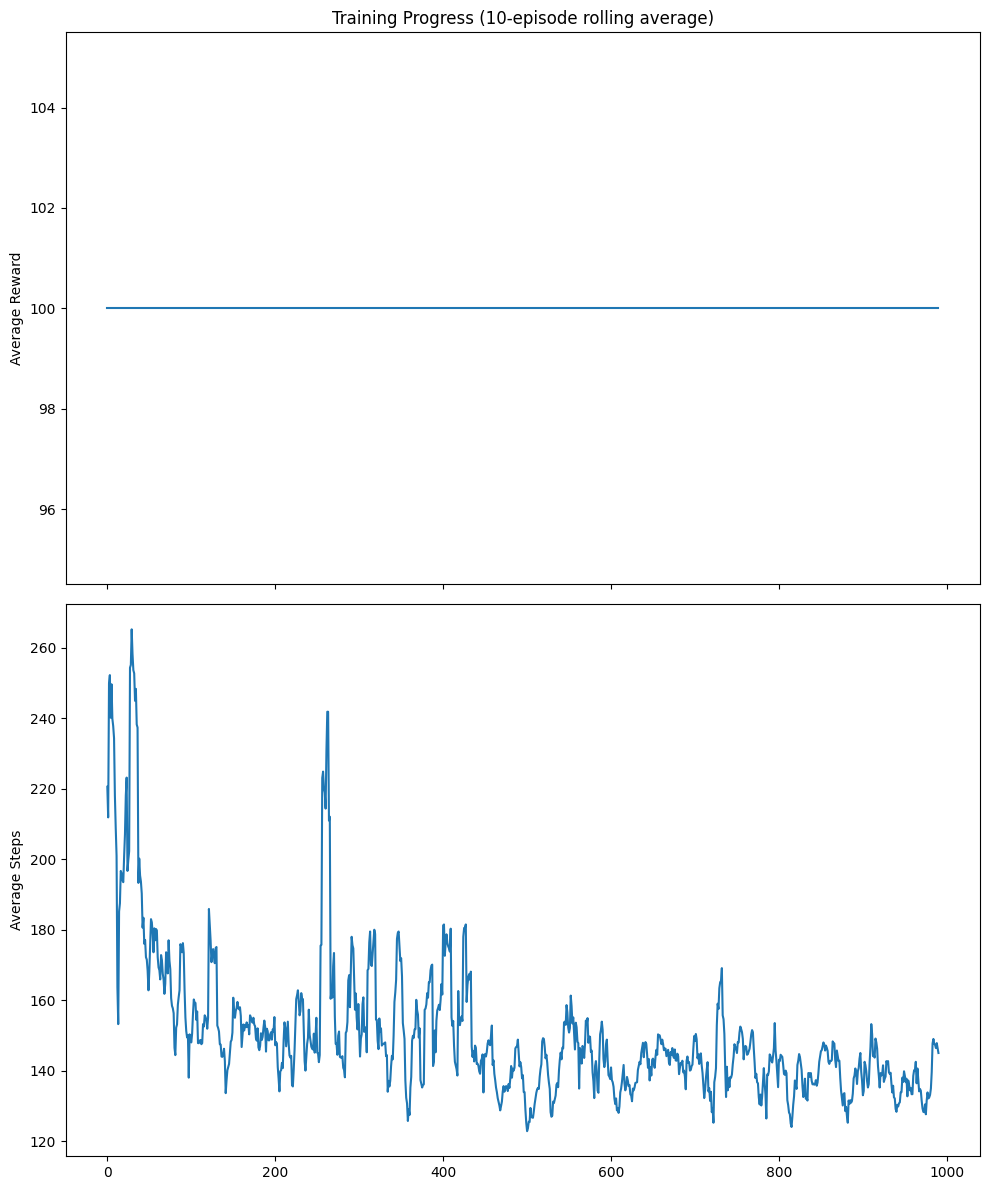

In [41]:
import matplotlib.pyplot as plt

# Calculate rolling averages
window_size = 10
rolling_rewards = np.convolve(rewards_history, np.ones(window_size)/window_size, mode='valid')
rolling_steps = np.convolve(steps_history, np.ones(window_size)/window_size, mode='valid')
rolling_success = np.convolve([1 if s else 0 for s in success_history], np.ones(window_size)/window_size, mode='valid') * 100

# Create the plots
# fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 12), sharex=True)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12), sharex=True)

# Plot rewards
ax1.plot(rolling_rewards)
ax1.set_ylabel('Average Reward')
ax1.set_title('Training Progress (10-episode rolling average)')

# Plot steps
ax2.plot(rolling_steps)
ax2.set_ylabel('Average Steps')

# Plot success rate
#ax3.plot(rolling_success)
#ax3.set_ylabel('Success Rate (%)')
#ax3.set_xlabel('Episode')

plt.tight_layout()
plt.show()

### Testing the Trained Agent

Now let's evaluate our trained agent with exploration turned off to see how well it performs on unseen seeds:

In [42]:
# Turn off exploration for evaluation
ql_agent_full.exploration_rate = 0

# Create test environment
test_env = SailingEnv(**get_initial_windfield('training_1'))

# Test parameters
num_test_episodes = 5
max_steps = 1000

print("Testing the trained agent on 5 new episodes...")
# Testing loop
for episode in range(num_test_episodes):
    # Reset environment
    observation, info = test_env.reset(seed=1000 + episode)  # Different seeds from training
    
    total_reward = 0
    
    for step in range(max_steps):
        # Select action using learned policy
        action = ql_agent_full.act(observation)
        observation, reward, done, truncated, info = test_env.step(action)
        
        total_reward += reward
        
        # Break if episode is done
        if done or truncated:
            break
    
    print(f"Test Episode {episode+1}: Steps={step+1}, Reward={total_reward}, " +
          f"Position={info['position']}, Goal reached={done}")

Testing the trained agent on 5 new episodes...
Test Episode 1: Steps=141, Reward=100.0, Position=[16 30], Goal reached=True
Test Episode 2: Steps=228, Reward=100.0, Position=[17 31], Goal reached=True
Test Episode 3: Steps=97, Reward=100.0, Position=[17 30], Goal reached=True
Test Episode 4: Steps=140, Reward=100.0, Position=[16 30], Goal reached=True
Test Episode 5: Steps=188, Reward=100.0, Position=[17 31], Goal reached=True


### Visualizing Your Agent's Behavior

While training metrics provide quantitative insights, actually seeing your agent navigate through the environment can reveal critical information about its behavior and strategy.

#### Using evaluate_agent.ipynb for Visualization

The `evaluate_agent.ipynb` notebook provides powerful visualization tools that let you see:
- Complete trajectories across different initial windfields
- How your agent responds to wind conditions
- Frame-by-frame animations of navigation decisions

To use these visualizations, you'll need to save your agent in the proper format first, which we'll do in the next section. Once saved, you can:

1. Open `evaluate_agent.ipynb`
2. Set `AGENT_PATH` to your saved agent file
3. Run the evaluation cells to generate visualizations

These visual insights can help you identify patterns, diagnose issues, and refine your agent's strategy in ways that metrics alone cannot reveal.

## Saving Your Agent for Submission

Now let's save our trained agent as a Python file that can be used for evaluation and submission. This step is crucial for three key reasons:

1. **Visualization and Testing**: Saving allows you to use the `evaluate_agent.ipynb` notebook to visualize trajectories and test performance across different scenarios.

2. **Validation and Evaluation**: The saved agent can be validated with `validate_agent.ipynb` and thoroughly evaluated using different seeds and initial windfields with `evaluate_agent.ipynb`. These notebooks provide important metrics and visualizations to understand your agent's performance.

3. **Submission Format**: Any agent submitted to the evaluator **must** be in this format - a single standalone Python (.py) file with a class that inherits from `BaseAgent` and implements all required methods. This is the official submission format for the challenge.

For Q-learning agents like ours, we've created a utility function `save_qlearning_agent()` in `src/utils/agent_utils.py` that handles the process of saving the agent with all its learned parameters. This creates a standalone Python file ready for submission.

This utility function:
1. Extracts the Q-table from your trained agent
2. Creates a new Python file with a clean agent implementation
3. Embeds the learned Q-values directly in the code
4. Includes all the necessary methods (act, reset, seed, etc.)

In [11]:
# Import the utility function for saving Q-learning agents
from src.utils.agent_utils import save_qlearning_agent

# Save our trained agent
save_qlearning_agent(
    agent=ql_agent_full,
    output_path="../src/agents/agent_trained_example.py"
)

Agent saved to ../src/agents/agent_trained_example.py
The file contains 514 state-action pairs.
You can now use this file with validate_agent.ipynb and evaluate_agent.ipynb


### Extending the Utility for Your Own Agents

If you implement different types of agents (such as DQN, SARSA, or custom algorithms), you may need to create similar utility functions. Some tips:

1. Make sure your save function preserves all necessary parameters and learned values
2. Store them in a way that doesn't require additional files (embedded in the code)
3. Ensure the saved agent includes all required methods from the BaseAgent interface

When extending `save_qlearning_agent()` for different Q-learning variants, you might need to:
- Update the state discretization logic
- Change how parameters are stored and initialized
- Modify the act() method's logic for your specific algorithm

### Agent Types and Saving Strategies

**For Rule-Based Agents:**
- Since rule-based agents don't have learned parameters, you can simply ensure your agent class follows the `BaseAgent` interface
- Implement all required methods: `__init__()`, `act(observation)`, `reset()`, and `seed(seed)`
- These are typically the simplest to save as the agent's logic is entirely defined in the code

**For Deep Learning-Based Agents:**
- Include the model architecture definition directly in your Python file
- Convert model weights to numpy arrays and include them in your code
- Add functions to rebuild the model from these arrays

### Key Requirements for Any Submission File

Regardless of your agent type, ensure your submission file:
1. **Contains everything**: All code, parameters, and data needed to run the agent
2. **Is a single file**: No external dependencies beyond standard libraries
3. **Follows the interface**: Properly inherits from `BaseAgent` and implements all required methods
4. **Requires no arguments**: The agent must initialize without any required arguments
5. **Is deterministic**: For a given seed, the agent should behave identically each time

## Important Note on Import Paths

When creating agent files for submission, make sure to use the correct import paths:
- **Use**: `from agents.base_agent import BaseAgent`
- **Not**: `from src.agents.base_agent import BaseAgent`

This is because the validation and evaluation scripts run from within the `src` directory, so imports should be relative to that location. Our utility function `save_qlearning_agent` already handles this for you.

## Automating Agent Training and Evaluation

The approach we've taken here is interactive and educational, but for serious agent development, you'll likely want to automate the training process. Here's where you could expand:

```python
# Your training script could look something like this:
def train_agent(agent, initial_windfields, num_episodes, save_path):
    # Setup training parameters
    # ...
    
    # Train on multiple initial windfields
    for initial_windfield_name, initial_windfield in initial_windfields.items():
        # Train agent on this initial_windfields
        # ...
        
    # Save the trained agent
    # ...
    
    return training_metrics
```

Creating a command-line interface for training and evaluation would allow you to:
1. Train agents with different hyperparameters
2. Evaluate on multiple initial_windfields 
3. Create systematic experiments

This is left as an exercise for you to implement based on your specific approach.

## Conclusion and Next Steps

In this notebook, we've covered:

1. **Agent Requirements**: Understanding the BaseAgent interface 
2. **The Naive Agent**: Examining a simple rule-based agent 
3. **Simplified Q-Learning Agent**: Implementing and training a basic RL agent that uses only local information (position, velocity, and local wind)

### Next Steps for Developing Your Own Agent

Now it's your turn to develop your own agent. Here are some suggestions:

1. **Enhance the Q-Learning Agent**:
   - Extend the state representation to incorporate the full wind field (not just local wind)
   - This would allow the agent to anticipate wind changes and plan better routes
   - Hint: Modify the `discretize_state` method to extract and process relevant features from the flattened wind field

2. **Algorithmic Improvements**:
   - Implement function approximation to handle continuous state spaces better
   - Explore other RL algorithms like SARSA, Expected SARSA, or Deep Q-Networks
   - Experiment with different exploration strategies that adapt over time

3. **Physics-Based Approaches**:
   - Leverage your understanding of sailing physics (from challenge_walkthrough notebook)
   - Implement rule-based algorithms or path planning (A*, etc.) that take advantage of domain knowledge
   - Create hybrid approaches that combine RL with domain-specific rules
   
### Validating and Evaluating Your Agent

After you've developed your agent, the next steps are to:

1. **Validate your agent** using the `validate_agent.ipynb` notebook or command-line tool
2. **Evaluate your agent** using the `evaluate_agent.ipynb` notebook

Remember that agents combining multiple techniques often perform best - consider how you might blend RL with domain knowledge of sailing physics for optimal results!

Good luck with the Sailing Challenge!

In [44]:
pip install torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 865.0/865.0 MB 40.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 393.1/393.1 MB 62.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 50.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 83.4 MB/s eta 0:00:00ta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.7/897.7 kB 25.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 571.0/571.0 MB 53.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.2/200.2 MB 69.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 39.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 81.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.2/158.2 MB 73.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.6/216.6 MB 76.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [54]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical
from src.agents.base_agent import BaseAgent

class PPOSailingAgent(BaseAgent):
    """Agent utilisant Proximal Policy Optimization (PPO) pour le Sailing Challenge."""
    
    def __init__(self, 
                 learning_rate=0.0003,
                 gamma=0.99,
                 gae_lambda=0.95,
                 clip_param=0.2,
                 value_coef=0.5,
                 entropy_coef=0.01,
                 max_grad_norm=0.5,
                 ppo_epochs=4,
                 mini_batch_size=64,
                 use_sailing_features=True):
        """
        Initialise l'agent PPO.
        
        Args:
            learning_rate: Taux d'apprentissage pour l'optimiseur
            gamma: Facteur d'actualisation pour les récompenses
            gae_lambda: Paramètre lambda pour l'estimation d'avantage généralisée
            clip_param: Paramètre d'écrêtage pour PPO
            value_coef: Coefficient pour la perte de la fonction de valeur
            entropy_coef: Coefficient pour le bonus d'entropie
            max_grad_norm: Norme maximale du gradient pour l'écrêtage
            ppo_epochs: Nombre d'époques pour chaque mise à jour PPO
            mini_batch_size: Taille des mini-lots pour l'entraînement
            use_sailing_features: Utiliser des caractéristiques spécifiques à la voile
        """
        super().__init__()
        self.np_random = np.random.default_rng()
        
        # Paramètres PPO
        self.lr = learning_rate
        self.gamma = gamma
        self.gae_lambda = gae_lambda
        self.clip_param = clip_param
        self.value_coef = value_coef
        self.entropy_coef = entropy_coef
        self.max_grad_norm = max_grad_norm
        self.ppo_epochs = ppo_epochs
        self.mini_batch_size = mini_batch_size
        
        # Paramètres d'environnement
        self.observation_dim = 2050  # x, y, vx, vy, wx, wy + wind field (32x32x2)
        self.action_dim = 9         # 8 directions + stay in place
        
        # Construction des réseaux
        self.use_sailing_features = use_sailing_features
        hidden_dim = 256
        
        # Définir la taille d'entrée en fonction de l'utilisation des caractéristiques de voile
        input_dim = self.observation_dim
        if self.use_sailing_features:
            # Si nous utilisons des caractéristiques extraites, la dimension d'entrée est plus petite
            input_dim = 25  # Caractéristiques extraites au lieu de l'observation brute
        
        # Réseaux pour la politique et la valeur
        self.policy_value_network = PolicyValueNetwork(input_dim, hidden_dim, self.action_dim)
        
        # Optimiseur
        self.optimizer = optim.Adam(self.policy_value_network.parameters(), lr=self.lr)
        
        # Mémoire pour stocker les expériences
        self.memory = PPOMemory()
        
        # Appareil d'exécution (CPU ou GPU)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.policy_value_network.to(self.device)
        
        # Compteurs
        self.training_step = 0
        
        # Position de l'objectif (sera mise à jour lors de l'initialisation de l'environnement)
        self.goal_position = np.array([16, 31])  # Valeur par défaut
        
        # Indice d'efficacité de navigation
        self.sailing_efficiency = self._create_sailing_efficiency()
    
    def _create_sailing_efficiency(self):
        """
        Crée une table d'efficacité de navigation basée sur l'angle au vent.
        Cette connaissance sera utilisée pour l'extraction de caractéristiques.
        """
        efficiency = {}
        
        # Zone de non-navigation (irons) - très faible efficacité
        for angle in range(0, 46):
            efficiency[angle] = 0.1
            efficiency[360-angle] = 0.1
        
        # Près (close-hauled) - efficacité modérée
        for angle in range(46, 80):
            factor = (angle - 45) / 35  # Augmentation progressive de l'efficacité
            efficiency[angle] = 0.3 + 0.4 * factor
            efficiency[360-angle] = 0.3 + 0.4 * factor
        
        # Travers (beam reach) - haute efficacité
        for angle in range(80, 120):
            efficiency[angle] = 0.9 + 0.1 * np.sin((angle - 80) * np.pi / 80)
            efficiency[360-angle] = 0.9 + 0.1 * np.sin((angle - 80) * np.pi / 80)
        
        # Grand largue (broad reach) - très haute efficacité
        for angle in range(120, 150):
            efficiency[angle] = 0.95
            efficiency[360-angle] = 0.95
        
        # Vent arrière (running) - haute efficacité mais pas optimale
        for angle in range(150, 181):
            factor = (180 - angle) / 30  # Diminution progressive
            efficiency[angle] = 0.85 + 0.1 * factor
            efficiency[360-angle] = 0.85 + 0.1 * factor
        
        return efficiency
    
    def extract_features(self, observation):
        """
        Extrait des caractéristiques pertinentes de l'observation brute.
        Cette étape est cruciale pour réduire la dimensionnalité et incorporer
        des connaissances spécifiques à la voile.
        
        Args:
            observation: Observation brute de l'environnement
        
        Returns:
            Vecteur de caractéristiques extraites
        """
        # Position et vitesse actuelles
        position = observation[:2]
        velocity = observation[2:4]
        wind_at_boat = observation[4:6]
        
        # Calculer la distance et la direction vers l'objectif
        direction_to_goal = self.goal_position - position
        distance_to_goal = np.linalg.norm(direction_to_goal)
        if distance_to_goal > 0:
            direction_to_goal = direction_to_goal / distance_to_goal  # Normaliser
        
        # Calcul des angles
        wind_speed = np.linalg.norm(wind_at_boat)
        wind_angle = np.degrees(np.arctan2(wind_at_boat[1], wind_at_boat[0])) % 360
        
        velocity_speed = np.linalg.norm(velocity)
        if velocity_speed > 0.01:
            velocity_angle = np.degrees(np.arctan2(velocity[1], velocity[0])) % 360
        else:
            velocity_angle = 0
        
        goal_angle = np.degrees(np.arctan2(direction_to_goal[1], direction_to_goal[0])) % 360
        
        # Angle relatif entre le vent et la direction vers l'objectif
        wind_to_goal_angle = (goal_angle - wind_angle) % 360
        
        # Angle relatif entre le vent et la vitesse
        wind_to_velocity_angle = (velocity_angle - wind_angle) % 360
        
        # Obtenir l'efficacité de navigation actuelle
        current_efficiency = self.sailing_efficiency.get(int(wind_to_velocity_angle), 0.5)
        
        # Indicateur de zone de non-navigation (upwind)
        upwind_condition = (wind_to_goal_angle < 45 or wind_to_goal_angle > 315)
        
        # Extraction de caractéristiques du champ de vent
        wind_field = observation[6:].reshape(-1, 2)  # Supposons que c'est un champ 2D
        
        # Calcul de statistiques sur le vent dans différentes régions
        # (cela pourrait être plus sophistiqué avec une segmentation appropriée)
        mid_point = len(wind_field) // 2
        quarter_point = mid_point // 2
        
        # Moyennes des vents dans différentes régions
        wind_north = np.mean(wind_field[mid_point+quarter_point:], axis=0)
        wind_south = np.mean(wind_field[:mid_point-quarter_point], axis=0)
        wind_east = np.mean(wind_field[mid_point-quarter_point:mid_point+quarter_point], axis=0)
        
        # Caractéristiques spécifiques à la voile pour différentes manœuvres
        # Possibilité de virement de bord (tacking)
        port_tack_angle = (wind_angle + 60) % 360
        starboard_tack_angle = (wind_angle - 60) % 360
        
        # Angles relatifs des virements par rapport à l'objectif
        port_tack_to_goal = min((port_tack_angle - goal_angle) % 360, (goal_angle - port_tack_angle) % 360)
        starboard_tack_to_goal = min((starboard_tack_angle - goal_angle) % 360, (goal_angle - starboard_tack_angle) % 360)
        
        # Créer le vecteur de caractéristiques
        features = np.array([
            # Position normalisée
            position[0] / 32.0,  # Normaliser par la taille de la grille
            position[1] / 32.0,
            
            # Vitesse et direction
            velocity_speed,
            np.sin(np.radians(velocity_angle)),
            np.cos(np.radians(velocity_angle)),
            
            # Vent local
            wind_speed,
            np.sin(np.radians(wind_angle)),
            np.cos(np.radians(wind_angle)),
            
            # Objectif
            distance_to_goal / 45.0,  # Normaliser par la distance max possible
            np.sin(np.radians(goal_angle)),
            np.cos(np.radians(goal_angle)),
            
            # Angles relatifs
            np.sin(np.radians(wind_to_goal_angle)),
            np.cos(np.radians(wind_to_goal_angle)),
            np.sin(np.radians(wind_to_velocity_angle)),
            np.cos(np.radians(wind_to_velocity_angle)),
            
            # Efficacité de navigation
            current_efficiency,
            
            # Indicateurs de conditions
            1.0 if upwind_condition else 0.0,
            
            # Statistiques régionales du vent
            wind_north[0], wind_north[1],
            wind_south[0], wind_south[1],
            wind_east[0], wind_east[1],
            
            # Caractéristiques de virement
            port_tack_to_goal / 180.0,  # Normaliser
            starboard_tack_to_goal / 180.0
        ])
        
        return features
        
    def act(self, observation):
        """
        Sélectionne une action basée sur l'observation actuelle.
        
        Args:
            observation: Observation de l'environnement
        
        Returns:
            L'action choisie
        """
        # Convertir l'observation en caractéristiques si nécessaire
        if self.use_sailing_features:
            state = self.extract_features(observation)
        else:
            state = observation
        
        # Convertir en tensor et déplacer vers l'appareil d'exécution
        state = torch.FloatTensor(state).unsqueeze(0).to(self.device)
        
        # Passer le state au réseau et obtenir la distribution de politique
        with torch.no_grad():
            action_probs, state_value = self.policy_value_network(state)
        
        # Créer la distribution catégorielle
        distribution = Categorical(action_probs)
        
        # Échantillonner une action
        action = distribution.sample()
        
        # Stocker l'information pour l'apprentissage
        self.memory.store_action(action.item(), distribution.log_prob(action).item(), state_value.item())
        
        return action.item()
    
    def remember(self, observation, action, reward, next_observation, done):
        """
        Stocke une transition dans la mémoire.
        
        Args:
            observation: Observation actuelle
            action: Action prise
            reward: Récompense reçue
            next_observation: Prochaine observation
            done: Indicateur de fin d'épisode
        """
        # Convertir l'observation en caractéristiques si nécessaire
        if self.use_sailing_features:
            state = self.extract_features(observation)
            next_state = self.extract_features(next_observation) if next_observation is not None else None
        else:
            state = observation
            next_state = next_observation
        
        # Stocker la transition dans la mémoire
        self.memory.store_transition(state, reward, done)
        
        # Si l'épisode est terminé, calculer les avantages et préparer pour l'apprentissage
        if done:
            self.memory.finish_trajectory(last_value=0)
        
    def learn(self):
        """
        Exécute l'apprentissage PPO sur les expériences collectées.
        """
        # Vérifier s'il y a suffisamment de données pour l'apprentissage
        if len(self.memory) < self.mini_batch_size:
            return
        
        # Récupérer les données de la mémoire
        states, actions, old_log_probs, returns, advantages = self.memory.get_all()
        
        # Convertir en tensors
        states = torch.FloatTensor(np.vstack(states)).to(self.device)
        actions = torch.LongTensor(actions).to(self.device)
        old_log_probs = torch.FloatTensor(old_log_probs).to(self.device)
        returns = torch.FloatTensor(returns).to(self.device)
        advantages = torch.FloatTensor(advantages).to(self.device)
        
        # Normaliser les avantages (améliore la stabilité)
        advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)
        
        # Mise à jour par mini-lots
        indices = np.arange(len(states))
        
        for _ in range(self.ppo_epochs):
            # Mélanger les indices
            self.np_random.shuffle(indices)
            
            # Parcourir les mini-lots
            for start in range(0, len(indices), self.mini_batch_size):
                # Sélectionner le mini-lot
                batch_indices = indices[start:start + self.mini_batch_size]
                batch_states = states[batch_indices]
                batch_actions = actions[batch_indices]
                batch_old_log_probs = old_log_probs[batch_indices]
                batch_returns = returns[batch_indices]
                batch_advantages = advantages[batch_indices]
                
                # Passer les états au réseau
                action_probs, state_values = self.policy_value_network(batch_states)
                distribution = Categorical(action_probs)
                
                # Obtenir les nouveaux log probs et l'entropie
                new_log_probs = distribution.log_prob(batch_actions)
                entropy = distribution.entropy().mean()
                
                # Calculer le ratio
                ratio = torch.exp(new_log_probs - batch_old_log_probs)
                
                # Calcul des termes de perte clippés et non clippés
                surr1 = ratio * batch_advantages
                surr2 = torch.clamp(ratio, 1.0 - self.clip_param, 1.0 + self.clip_param) * batch_advantages
                
                # Pertes
                policy_loss = -torch.min(surr1, surr2).mean()
                value_loss = F.mse_loss(state_values.squeeze(), batch_returns)
                
                # Perte totale
                loss = policy_loss + self.value_coef * value_loss - self.entropy_coef * entropy
                
                # Mise à jour des poids
                self.optimizer.zero_grad()
                loss.backward()
                # Écrêtage du gradient (évite les mises à jour trop grandes)
                nn.utils.clip_grad_norm_(self.policy_value_network.parameters(), self.max_grad_norm)
                self.optimizer.step()
        
        # Réinitialiser la mémoire
        self.memory.clear()
        
        # Incrémenter le compteur d'étapes d'entraînement
        self.training_step += 1
    
    def reset(self):
        """Réinitialise l'agent pour un nouvel épisode."""
        # Rien à faire pour PPO ici car la mémoire est gérée séparément
        pass
    
    def seed(self, seed=None):
        """Définit la graine aléatoire."""
        self.np_random = np.random.default_rng(seed)
        torch.manual_seed(seed)
        if torch.cuda.is_available():
            torch.cuda.manual_seed(seed)
    
    def save(self, path):
        """Sauvegarde le modèle."""
        torch.save({
            'policy_value_network': self.policy_value_network.state_dict(),
            'optimizer': self.optimizer.state_dict(),
            'training_step': self.training_step
        }, path)
    
    def load(self, path):
        """Charge le modèle."""
        checkpoint = torch.load(path, map_location=self.device)
        self.policy_value_network.load_state_dict(checkpoint['policy_value_network'])
        self.optimizer.load_state_dict(checkpoint['optimizer'])
        self.training_step = checkpoint['training_step']


class PolicyValueNetwork(nn.Module):
    """Réseau de politique et de valeur pour PPO."""
    
    def __init__(self, input_dim, hidden_dim, output_dim):
        """
        Initialise le réseau.
        
        Args:
            input_dim: Dimension de l'entrée (observation)
            hidden_dim: Dimension des couches cachées
            output_dim: Dimension de la sortie (nombre d'actions)
        """
        super(PolicyValueNetwork, self).__init__()
        
        # Couches partagées
        self.shared = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )
        
        # Couches de politique (actor)
        self.policy = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, output_dim),
            nn.Softmax(dim=-1)
        )
        
        # Couches de valeur (critic)
        self.value = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, 1)
        )
    
    def forward(self, x):
        """
        Passe avant dans le réseau.
        
        Args:
            x: Entrée (observation)
        
        Returns:
            Tuple (probabilités d'action, valeur d'état)
        """
        shared_features = self.shared(x)
        action_probs = self.policy(shared_features)
        state_value = self.value(shared_features)
        
        return action_probs, state_value


class PPOMemory:
    """Mémoire pour stocker les expériences pour PPO."""
    
    def __init__(self):
        """Initialise la mémoire."""
        self.states = []
        self.actions = []
        self.log_probs = []
        self.rewards = []
        self.values = []
        self.dones = []
        
        # Ajouter ces attributs manquants
        self.returns = []
        self.advantages = []
        
        # Variables temporaires pour la trajectoire en cours
        self.current_states = []
        self.current_actions = []
        self.current_log_probs = []
        self.current_rewards = []
        self.current_values = []
        self.current_dones = []
    
    def store_action(self, action, log_prob, value):
        """
        Stocke l'action, son log de probabilité et la valeur d'état.
        
        Args:
            action: Action prise
            log_prob: Log de probabilité de l'action
            value: Valeur d'état estimée
        """
        self.current_actions.append(action)
        self.current_log_probs.append(log_prob)
        self.current_values.append(value)
    
    def store_transition(self, state, reward, done):
        """
        Stocke une transition.
        
        Args:
            state: État actuel
            reward: Récompense reçue
            done: Indicateur de fin d'épisode
        """
        self.current_states.append(state)
        self.current_rewards.append(reward)
        self.current_dones.append(done)
    
    def finish_trajectory(self, last_value=0, gamma=0.99, gae_lambda=0.95):
        """
        Finalise la trajectoire en cours et calcule les avantages et retours.
        
        Args:
            last_value: Valeur d'état du dernier état (0 si épisode terminé)
            gamma: Facteur d'actualisation
            gae_lambda: Paramètre lambda pour GAE
        """
        # S'assurer qu'il y a des données
        if len(self.current_rewards) == 0:
            return
        
        # Calcul des avantages et retours
        rewards = np.array(self.current_rewards + [last_value])
        values = np.array(self.current_values + [last_value])
        dones = np.array(self.current_dones + [1])  # Considérer le dernier état comme terminé
        
        # Calcul des avantages avec Generalized Advantage Estimation (GAE)
        deltas = rewards[:-1] + gamma * values[1:] * (1 - dones[:-1]) - values[:-1]
        advantages = []
        advantage = 0
        
        for delta, done in zip(reversed(deltas), reversed(dones[:-1])):
            advantage = delta + gamma * gae_lambda * advantage * (1 - done)
            advantages.append(advantage)
        
        advantages.reverse()
        
        # Calcul des retours (valeur cible)
        returns = advantages + np.array(self.current_values)
        
        # Ajouter aux listes de stockage
        self.states.extend(self.current_states)
        self.actions.extend(self.current_actions)
        self.log_probs.extend(self.current_log_probs)
        self.rewards.extend(self.current_rewards)
        self.values.extend(self.current_values)
        self.dones.extend(self.current_dones)
        
        # Ajouter les avantages et retours calculés
        self.advantages.extend(advantages)
        self.returns.extend(returns)
        
        # Réinitialiser les variables temporaires
        self.current_states = []
        self.current_actions = []
        self.current_log_probs = []
        self.current_rewards = []
        self.current_values = []
        self.current_dones = []
    
    def get_all(self):
        """
        Récupère toutes les données de la mémoire.
        
        Returns:
            Tuple (états, actions, log_probs, retours, avantages)
        """
        return (
            self.states,
            self.actions,
            self.log_probs,
            self.returns,
            self.advantages
        )
    
    def clear(self):
        """Efface la mémoire."""
        self.states = []
        self.actions = []
        self.log_probs = []
        self.rewards = []
        self.values = []
        self.dones = []
        self.returns = []
        self.advantages = []
    
    def __len__(self):
        """Retourne la taille de la mémoire."""
        return len(self.states)

In [55]:
import numpy as np
from src.env_sailing import SailingEnv
from src.initial_windfields import get_initial_windfield

# Créer notre agent PPO
ppo_agent = PPOSailingAgent(
    learning_rate=0.0003,
    gamma=0.99,
    gae_lambda=0.95,
    clip_param=0.2,
    value_coef=0.5,
    entropy_coef=0.01,
    max_grad_norm=0.5,
    ppo_epochs=4,
    mini_batch_size=64,
    use_sailing_features=True
)

# Définir une graine fixe pour la reproductibilité
np.random.seed(42)
ppo_agent.seed(42)

# Créer l'environnement avec un champ de vent
env = SailingEnv(**get_initial_windfield('simple_static'))

# Paramètres d'entraînement
num_episodes = 100
max_steps = 1000
batch_size = 2048  # Taille du lot pour PPO (nombre d'étapes avant la mise à jour)
update_frequency = 2048  # Fréquence de mise à jour (en pas)

# Variables pour le suivi
total_steps = 0
episode_rewards = []
episode_lengths = []

# Boucle d'entraînement
print("Starting PPO training...")
for episode in range(num_episodes):
    # Réinitialiser l'environnement et obtenir l'état initial
    observation, info = env.reset(seed=episode)
    
    # Informer l'agent de la position de l'objectif
    ppo_agent.goal_position = env.goal_position if hasattr(env, 'goal_position') else np.array([16, 31])
    
    episode_reward = 0
    episode_length = 0
    
    # Boucle d'un épisode
    for step in range(max_steps):
        # Sélectionner et exécuter une action
        action = ppo_agent.act(observation)
        next_observation, reward, done, truncated, info = env.step(action)
        
        # Stocker la transition
        ppo_agent.remember(observation, action, reward, next_observation, done or truncated)
        
        # Mettre à jour l'observation et les compteurs
        observation = next_observation
        episode_reward += reward
        episode_length += 1
        total_steps += 1
        
        # Apprendre si c'est le moment
        if total_steps % update_frequency == 0:
            ppo_agent.learn()
        
        # Sortir si l'épisode est terminé
        if done or truncated:
            # Finaliser la trajectoire
            if not done:  # Si tronqué mais pas terminé, estimer la valeur finale
                # Convertir l'observation en caractéristiques si nécessaire
                if ppo_agent.use_sailing_features:
                    state = ppo_agent.extract_features(observation)
                else:
                    state = observation
                
                # Obtenir la valeur d'état finale
                state_tensor = torch.FloatTensor(state).unsqueeze(0).to(ppo_agent.device)
                with torch.no_grad():
                    _, state_value = ppo_agent.policy_value_network(state_tensor)
                last_value = state_value.item()
            else:
                last_value = 0  # Épisode terminé, pas de récompense future
            
            ppo_agent.memory.finish_trajectory(last_value=last_value)
            break
    
    # Enregistrer les statistiques de l'épisode
    episode_rewards.append(episode_reward)
    episode_lengths.append(episode_length)
    
    # Afficher les progrès
    avg_reward = np.mean(episode_rewards[-10:]) if len(episode_rewards) >= 10 else np.mean(episode_rewards)
    avg_length = np.mean(episode_lengths[-10:]) if len(episode_lengths) >= 10 else np.mean(episode_lengths)
    
    print(f"Episode {episode+1}: Steps={episode_length}, Reward={episode_reward}, " +
          f"Position={info['position']}, Goal reached={done}")
    
    if (episode + 1) % 10 == 0:
        print(f"Average over last 10 episodes: Reward={avg_reward:.2f}, Length={avg_length:.2f}")
        
        # Sauvegarder le modèle périodiquement
        ppo_agent.save(f"ppo_sailing_agent_ep{episode+1}.pt")

print("\nTraining completed!")
print(f"Final average reward (last 10 episodes): {np.mean(episode_rewards[-10:]):.2f}")

# Sauvegarder le modèle final
ppo_agent.save("ppo_sailing_agent_final.pt")

# Test de l'agent entraîné
print("\nTesting trained agent...")
observation, info = env.reset(seed=1000)  # Nouvelle graine pour le test
total_reward = 0
step_count = 0

# Désactiver l'exploration pour le test
is_training = False

while step_count < 500:
    action = ppo_agent.act(observation)
    observation, reward, done, truncated, info = env.step(action)
    total_reward += reward
    step_count += 1
    
    if step_count % 50 == 0:
       print(f"Test - Step {step_count}: Position={info['position']}, Reward={reward}")
   
    if done or truncated:
       break

print(f"\nTest completed after {step_count} steps with reward: {total_reward}")
print(f"Final position: {info['position']}")
print(f"Goal reached: {done}")

Starting PPO training...
Episode 1: Steps=1000, Reward=0.0, Position=[1 0], Goal reached=True
Episode 2: Steps=1000, Reward=0.0, Position=[0 3], Goal reached=True
Episode 3: Steps=1000, Reward=0.0, Position=[0 7], Goal reached=True
Episode 4: Steps=1000, Reward=0.0, Position=[0 5], Goal reached=True
Episode 5: Steps=1000, Reward=0.0, Position=[3 0], Goal reached=True
Episode 6: Steps=1000, Reward=0.0, Position=[0 8], Goal reached=True
Episode 7: Steps=1000, Reward=0.0, Position=[0 5], Goal reached=True
Episode 8: Steps=1000, Reward=0.0, Position=[0 8], Goal reached=True
Episode 9: Steps=1000, Reward=0.0, Position=[ 2 11], Goal reached=True
Episode 10: Steps=1000, Reward=0.0, Position=[ 1 24], Goal reached=True
Average over last 10 episodes: Reward=0.00, Length=1000.00
Episode 11: Steps=1000, Reward=0.0, Position=[ 0 30], Goal reached=True
Episode 12: Steps=1000, Reward=0.0, Position=[ 2 25], Goal reached=True
Episode 13: Steps=1000, Reward=0.0, Position=[ 0 31], Goal reached=True
Episo

In [57]:
# Turn off exploration for evaluation
ppo_agent.evaluation_mode = True

# Create test environment
test_env = SailingEnv(**get_initial_windfield('training_1'))

# Test parameters
num_test_episodes = 5
max_steps = 1000

print("Testing the trained agent on 5 new episodes...")
# Testing loop
for episode in range(num_test_episodes):
    # Reset environment
    observation, info = test_env.reset(seed=1000 + episode)  # Different seeds from training
    
    total_reward = 0
    
    for step in range(max_steps):
        # Select action using learned policy
        action = ql_agent_full.act(observation)
        observation, reward, done, truncated, info = test_env.step(action)
        
        total_reward += reward
        
        # Break if episode is done
        if done or truncated:
            break
    
    print(f"Test Episode {episode+1}: Steps={step+1}, Reward={total_reward}, " +
          f"Position={info['position']}, Goal reached={done}")

Testing the trained agent on 5 new episodes...
Test Episode 1: Steps=146, Reward=100.0, Position=[15 31], Goal reached=True
Test Episode 2: Steps=116, Reward=100.0, Position=[15 30], Goal reached=True
Test Episode 3: Steps=99, Reward=100.0, Position=[16 30], Goal reached=True
Test Episode 4: Steps=143, Reward=100.0, Position=[16 31], Goal reached=True
Test Episode 5: Steps=146, Reward=100.0, Position=[16 30], Goal reached=True
